In [1]:
# this block of code is for multi-core optimization, to make the notebook faster and more efficient for computation intensive tasks.
# it is not needed if you are not using multi-core optimization, and it is not part of actual code itself

# Enable all optimizations
import time
from multiprocessing import cpu_count
from numba import jit

# Start timing
start_time = time.time()

# Display system information
print(f"Number of CPU cores: {cpu_count()}")

# Example of JIT-optimized function
@jit(nopython=True, parallel=True)
def heavy_computation(arr):
    result = 0
    for x in arr:
        result += x ** 2
    return result

# Print Optimization Ready
print("Optimizations enabled. Ready to execute.")

Number of CPU cores: 4
Optimizations enabled. Ready to execute.


# Exploratory Data Analysis (EDA)

## Table of Contents
1. [Dataset Overview](#dataset-overview)
2. [Handling Missing Values](#handling-missing-values)
3. [Feature Distributions](#feature-distributions)
4. [Possible Biases](#possible-biases)
5. [Correlations](#correlations)


## Initial Setup

In [2]:
# libraries for dataset operations
import pandas as pd
import numpy as np

# libraries for data visualization
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

# statistical tools
from scipy.stats import kurtosis, normaltest, shapiro
from statsmodels.tsa.stattools import adfuller, kpss, ccf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from scipy.signal import periodogram

# ignoring warnings
import warnings
warnings.filterwarnings('ignore')

In [3]:
# setting default number of rows and columns to be displayed
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)  # No limit on column width
pd.set_option('display.width', 200)  # Set a high enough width to prevent wrapping
pd.set_option('display.colheader_justify', 'center')  # Center column headers for readability

# adjusting CSS for the Jupyter Notebook, to avoid text-wrapping
from IPython.display import display, HTML
display(HTML("<style>.dataframe td { white-space: nowrap; }</style>"))

In [4]:
# number formatting for better readability

nf_0 = lambda x: f'{x:,.0f}' if isinstance(x, (int, float)) else x # rounding-off to 0 decimals with thousand separator (for integers)
nf_2 = lambda x: f'{x:,.2f}' if isinstance(x, (int, float)) else x # rounding-off to 2 decimals with thousand separator (for floats)
nf_2np = lambda x: f'{x:.2%}' if isinstance(x, (int, float)) else x # rounding-off to 2 decimals with percent sign, assuming the number is calculated as percentage and not displayed as percentage
nf_2pp = lambda x: f'{x/100:.2%}' if isinstance(x, (int, float)) else x # rounding-off to 2 decimals with percent sign, assuming the number is displayed as percentage but without percentage sign

## Dataset Overview

[Provide a high-level overview of the dataset. This should include the source of the dataset, the number of samples, the number of features, and example showing the structure of the dataset.]


In [5]:
# loading the dataset
df = pd.read_csv('https://raw.githubusercontent.com/kalakhushi18/Advance-Time-Series-Prediction-W24/refs/heads/main/dataset.csv')
# Number of samples
num_samples = df.shape[0]

# Number of features
num_features = df.shape[1]

# Display these dataset characteristics
print(f"Number of observations: {num_samples}")
print(f"Number of features: {num_features}")

# Display the first few rows of the dataframe to show the structure
print("Example data:")
print(df.head(10))


Number of observations: 3656
Number of features: 8
Example data:
      date     bitcoin_closing_prices  sp500_closing_data inflation_rate  daily_treasury_rates  bitcoin_daily_google_trends  is_holiday  twitter_sentiments_score
0  2014-11-01        325.748993                    NaN          NaN                NaN                      40                    1                NaN           
1  2014-11-02        325.891998                    NaN          NaN                NaN                      44                    1                NaN           
2  2014-11-03        327.553986            2017.810059         1.93               0.03                      46                    0                NaN           
3  2014-11-04        330.492004            2012.099976         1.92               0.04                      43                    0                NaN           
4  2014-11-05        339.485992            2023.569946         1.93               0.04                      45               

In [6]:
print(df.describe())

       bitcoin_closing_prices  sp500_closing_data  daily_treasury_rates  bitcoin_daily_google_trends  is_holiday   twitter_sentiments_score
count        3655.000000           2517.000000          2502.000000              3656.000000          3656.000000             0.0          
mean        18632.744444           3293.187358             1.628030                49.153446             0.314551             NaN          
std         20226.941042           1043.490524             1.847423                18.142972             0.464400             NaN          
min           178.102997           1829.079956            -0.040000                 9.000000             0.000000             NaN          
25%          1471.454956           2387.449951             0.090000                36.000000             0.000000             NaN          
50%          9330.549805           2964.330078             0.940000                47.000000             0.000000             NaN          
75%         30055.91

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3656 entries, 0 to 3655
Data columns (total 8 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   date                         3656 non-null   object 
 1   bitcoin_closing_prices       3655 non-null   float64
 2   sp500_closing_data           2517 non-null   float64
 3   inflation_rate               2610 non-null   object 
 4   daily_treasury_rates         2502 non-null   float64
 5   bitcoin_daily_google_trends  3656 non-null   int64  
 6   is_holiday                   3656 non-null   int64  
 7   twitter_sentiments_score     0 non-null      float64
dtypes: float64(4), int64(2), object(2)
memory usage: 228.6+ KB


## Typecasting

In [8]:
# changing 'date' column to datetime format
df['date'] = pd.to_datetime(df['date'])

# setting 'date' column as index
df.set_index('date', inplace=True)

In [9]:
# replacing '.' with np.nan in 'inflation_rate' column
df['inflation_rate'] = df['inflation_rate'].replace('.', np.nan)

In [10]:
# changing the type of 'inflation_rate' column to float
df['inflation_rate'] = df['inflation_rate'].astype(float)

## Handling Missing Values

[Identify any missing values in the dataset, and describe your approach to handle them if there are any. If there are no missing values simply indicate that there are none.]


In [11]:
# Check for missing values
missing_values_count = df.isnull().sum()
missing_values_percent = (df.isnull().sum() / len(df)) * 100
missing_values_percent = missing_values_percent.map(nf_2pp)
missing_values= pd.concat([missing_values_count, missing_values_percent], axis=1)
missing_values.columns = ['Count', 'Percentage']

print("Missing values:")
print(missing_values)

Missing values:
                             Count Percentage
bitcoin_closing_prices          1      0.03% 
sp500_closing_data           1139     31.15% 
inflation_rate               1154     31.56% 
daily_treasury_rates         1154     31.56% 
bitcoin_daily_google_trends     0      0.00% 
is_holiday                      0      0.00% 
twitter_sentiments_score     3656    100.00% 


<Axes: ylabel='date'>

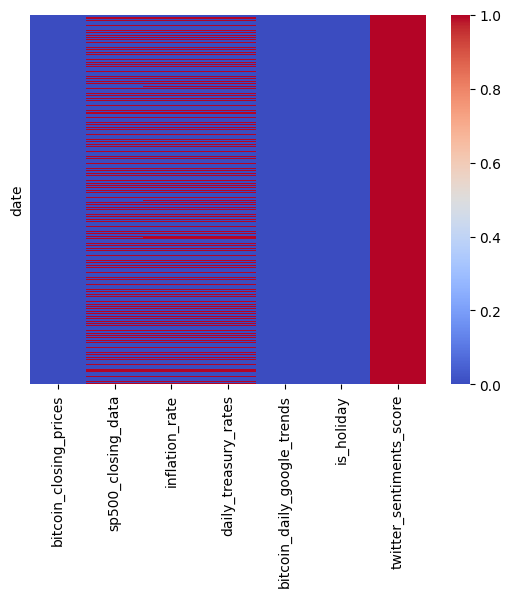

In [12]:
# heatmap of missing values with ytickslabels as date format mm-yyyy
sns.heatmap(df.isnull(), cmap='coolwarm', yticklabels=False)

In [13]:
# ffilling missing values in 'sp500_closing_data', 'inflation_rate' and 'daily_treasury_rate' columns
df['sp500_closing_data'] = df['sp500_closing_data'].fillna(method='ffill')
df['inflation_rate'] = df['inflation_rate'].fillna(method='ffill')
df['daily_treasury_rates'] = df['daily_treasury_rates'].fillna(method='ffill')

# bfilling missing values in 'sp500_closing_data', 'inflation_rate' and 'daily_treasury_rate' columns.
# this bfill is for date 01-Nov-2014 and 02-Nov-2014 only as days on these dates are Saturday and Sunday respectively
# and we have no data to ffill

df['sp500_closing_data'] = df['sp500_closing_data'].fillna(method='bfill')
df['inflation_rate'] = df['inflation_rate'].fillna(method='bfill')
df['daily_treasury_rates'] = df['daily_treasury_rates'].fillna(method='bfill')

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3656 entries, 2014-11-01 to 2024-11-03
Data columns (total 7 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   bitcoin_closing_prices       3655 non-null   float64
 1   sp500_closing_data           3656 non-null   float64
 2   inflation_rate               3656 non-null   float64
 3   daily_treasury_rates         3656 non-null   float64
 4   bitcoin_daily_google_trends  3656 non-null   int64  
 5   is_holiday                   3656 non-null   int64  
 6   twitter_sentiments_score     0 non-null      float64
dtypes: float64(5), int64(2)
memory usage: 228.5 KB


In [15]:
# Check for missing values
missing_values_count = df.isnull().sum()
missing_values_percent = (df.isnull().sum() / len(df)) * 100
missing_values_percent = missing_values_percent.map(nf_2pp)
missing_values= pd.concat([missing_values_count, missing_values_percent], axis=1)
missing_values.columns = ['Count', 'Percentage']

print("Missing values:")
print(missing_values)

Missing values:
                             Count Percentage
bitcoin_closing_prices          1      0.03% 
sp500_closing_data              0      0.00% 
inflation_rate                  0      0.00% 
daily_treasury_rates            0      0.00% 
bitcoin_daily_google_trends     0      0.00% 
is_holiday                      0      0.00% 
twitter_sentiments_score     3656    100.00% 


In [16]:
# checking dates where null values are present
df[df['bitcoin_closing_prices'].isnull()]

bitcoin_closing_prices  sp500_closing_data  inflation_rate  daily_treasury_rates  bitcoin_daily_google_trends  is_holiday  twitter_sentiments_score
date                                                                                                                                                           
2024-11-03           NaN                5728.799805          2.33               4.57                      52                    1                NaN

In [17]:
# dropping rows where bitcoin_closing_prices is null
df = df.dropna(subset=['bitcoin_closing_prices'])

In [18]:
# Check for missing values
missing_values_count = df.isnull().sum()
missing_values_percent = (df.isnull().sum() / len(df)) * 100
missing_values_percent = missing_values_percent.map(nf_2pp)
missing_values= pd.concat([missing_values_count, missing_values_percent], axis=1)
missing_values.columns = ['Count', 'Percentage']

print("Missing values:")
print(missing_values)

Missing values:
                             Count Percentage
bitcoin_closing_prices          0      0.00% 
sp500_closing_data              0      0.00% 
inflation_rate                  0      0.00% 
daily_treasury_rates            0      0.00% 
bitcoin_daily_google_trends     0      0.00% 
is_holiday                      0      0.00% 
twitter_sentiments_score     3655    100.00% 


## Feature Distributions and Possible Biases

[Plot the distribution of various features and target variables. Comment on the skewness, outliers, or any other observations.]

[Investigate the dataset for any biases that could affect the model’s performance and fairness (e.g., class imbalance, historical biases).]



In [19]:
# Define the variables to be plotted
variables = ['bitcoin_closing_prices',
             'sp500_closing_data',
             'inflation_rate',
             'daily_treasury_rates',
             'bitcoin_daily_google_trends'
             ]

                             Skewness Skewness Interpretation  Kurtosis Kurtosis Interpretation Bias Test (p-value) P-Value Interpretation Distribution
bitcoin_closing_prices       1.058929       Positive Skew     -0.096616        Platykurtic                 0.0             Reject H0        Not Normal 
sp500_closing_data           0.498084           Symmetric     -0.864392        Platykurtic                 0.0             Reject H0        Not Normal 
inflation_rate               -0.12177           Symmetric     -0.196712        Platykurtic            0.000339             Reject H0        Not Normal 
daily_treasury_rates         0.991512       Positive Skew     -0.434478        Platykurtic                 0.0             Reject H0        Not Normal 
bitcoin_daily_google_trends  0.473393           Symmetric     -0.126576        Platykurtic                 0.0             Reject H0        Not Normal 


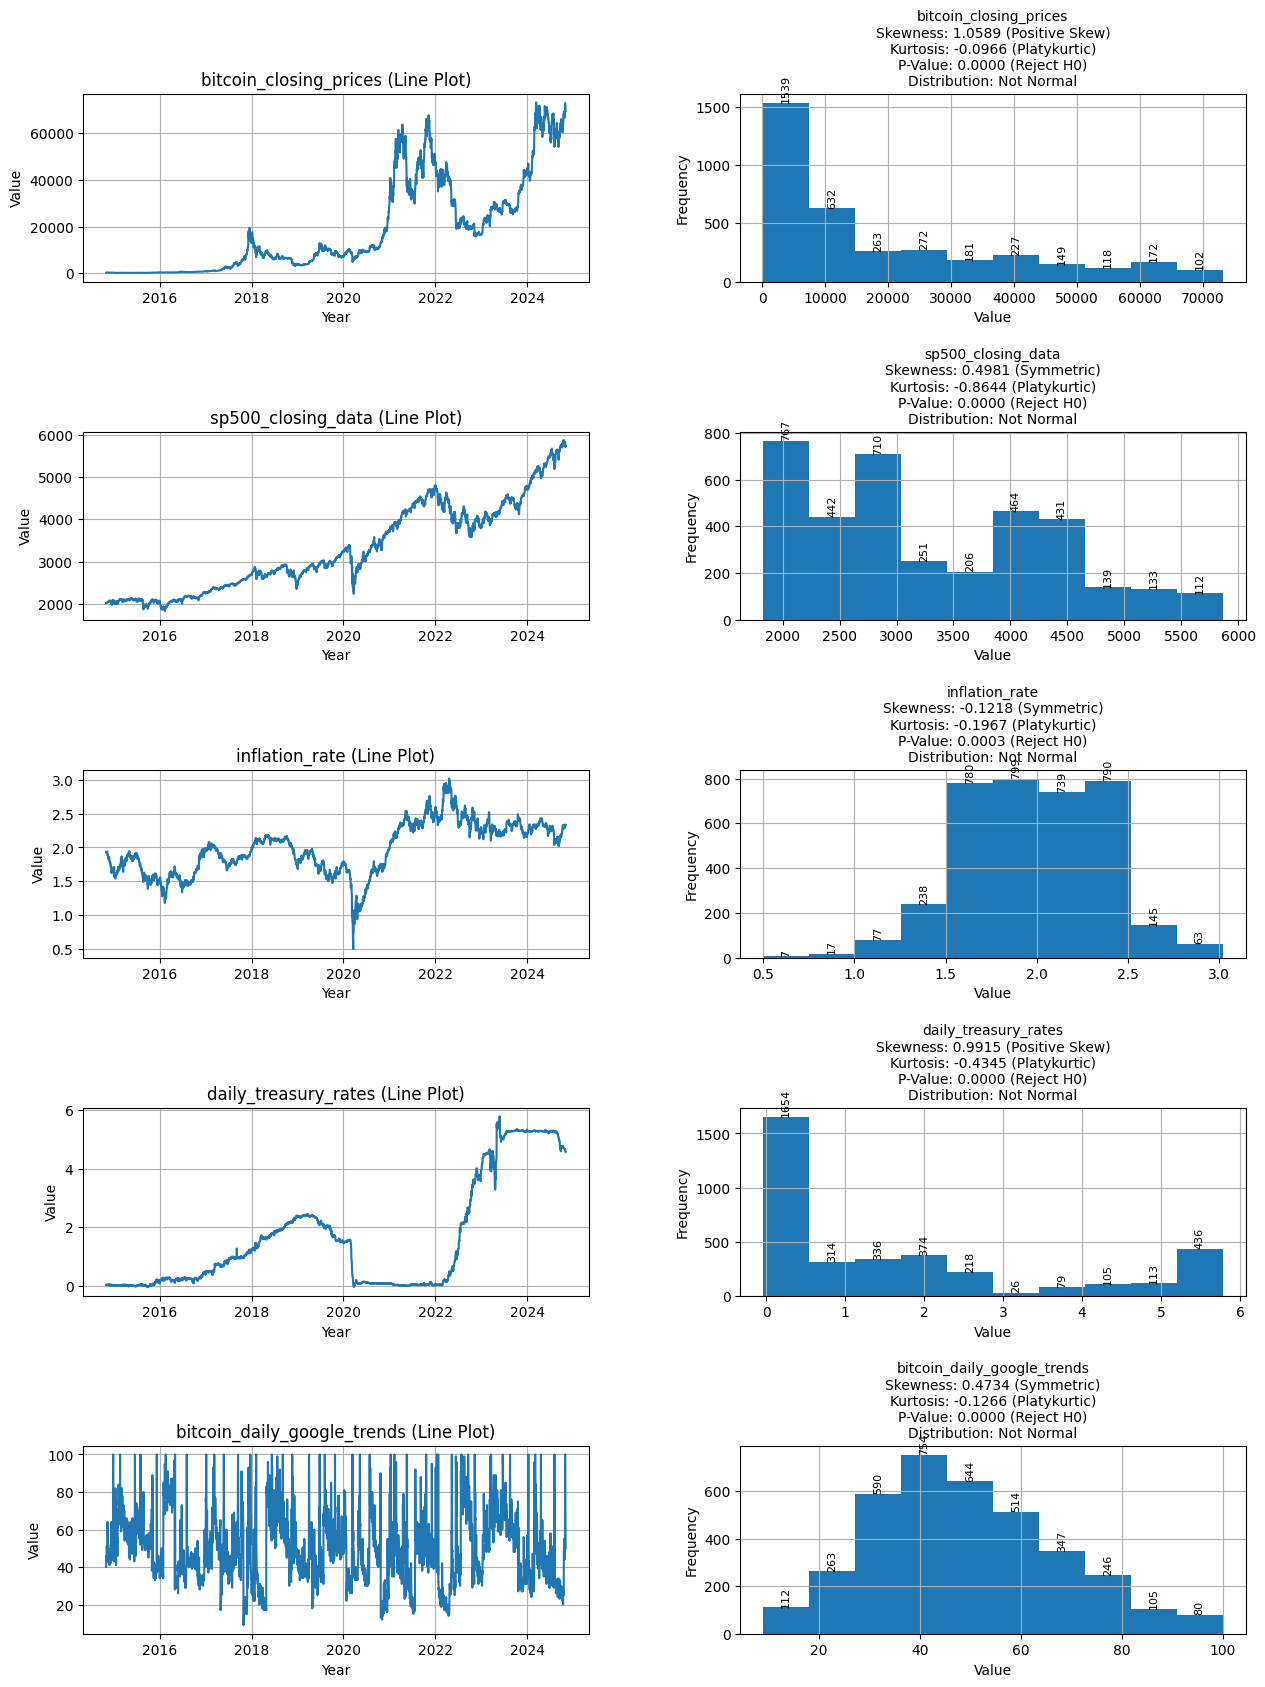

In [20]:
# Initialize an empty dictionary to store statistics and interpretations for each variable
stats_dict = {}

# Create a list to store the distribution results
distribution = []

# Compute statistical measures and interpretations for each variable
for col in variables:
    skew = df[col].skew()
    kurt = kurtosis(df[col], fisher=True)  # Fisher=True gives excess kurtosis
    _, p_value = normaltest(df[col].dropna())  # Test for normality (e.g., D’Agostino and Pearson’s test)

    # Interpret skewness
    if skew > 0.5:
        skew_interpretation = "Positive Skew"
    elif skew < -0.5:
        skew_interpretation = "Negative Skew"
    else:
        skew_interpretation = "Symmetric"

    # Interpret kurtosis
    if kurt > 0:
        kurt_interpretation = "Leptokurtic"
    elif kurt < 0:
        kurt_interpretation = "Platykurtic"
    else:
        kurt_interpretation = "Mesokurtic"

    # Interpret p-value
    p_value_interpretation = "Reject H0" if p_value < 0.05 else "Accept H0"
    
    # Add the distribution result based on the p-value
    if p_value >= 0.05:
        dist_interpretation = "Normal"
    else:
        dist_interpretation = "Not Normal"
    
    # Add to dictionary
    stats_dict[col] = {
        'Skewness': skew,
        'Skewness Interpretation': skew_interpretation,
        'Kurtosis': kurt,
        'Kurtosis Interpretation': kurt_interpretation,
        'Bias Test (p-value)': p_value,
        'P-Value Interpretation': p_value_interpretation,
        'Distribution': dist_interpretation  # New column for distribution
    }
    distribution.append(dist_interpretation)

# Create a DataFrame from the dictionary
stats_df = pd.DataFrame(stats_dict).T  # Transpose to get variables as rows
print(stats_df)

# Plotting line plots and histograms side by side
bins = 10
fig, axes = plt.subplots(len(variables), 2, figsize=(15, 20))

for i, col in enumerate(variables):
    # Plot the line chart
    axes[i, 0].plot(df.index, df[col], label=col)
    axes[i, 0].set_title(f"{col} (Line Plot)", fontsize=12)
    axes[i, 0].grid(True)
    axes[i, 0].set_ylabel('Value')
    axes[i, 0].set_xlabel('Year')

    # Compute skewness
    skewness = df[col].skew()
    kurtosis_value = kurtosis(df[col], fisher=True)
    p_value = normaltest(df[col].dropna())[1]
    
    # Get statistics from the dictionary
    skew = stats_dict[col]['Skewness']
    skew_interpretation = stats_dict[col]['Skewness Interpretation']
    kurt = stats_dict[col]['Kurtosis']
    kurt_interpretation = stats_dict[col]['Kurtosis Interpretation']
    p_value_interpretation = stats_dict[col]['P-Value Interpretation']
    dist_interpretation = stats_dict[col]['Distribution']
    
    # Plot histogram
    df[col].hist(bins=bins, ax=axes[i, 1])

    # Create the title with all statistics
    title = (f"{col}\n"
             f"Skewness: {skew:.4f} ({skew_interpretation})\n"
             f"Kurtosis: {kurt:.4f} ({kurt_interpretation})\n"
             f"P-Value: {p_value:.4f} ({p_value_interpretation})\n"
             f"Distribution: {dist_interpretation}")

    axes[i, 1].set_title(title, fontsize=10)
    axes[i, 1].set_xlabel("Value")
    axes[i, 1].set_ylabel("Frequency")
    
    # Display counts above each bar
    for container in axes[i, 1].containers:
        axes[i, 1].bar_label(container, rotation=90, fontsize=8)

# Adjust layout and add grid
plt.subplots_adjust(hspace=0.8, wspace=0.3)
plt.show()

## Possible Biases

[Investigate the dataset for any biases that could affect the model’s performance and fairness (e.g., class imbalance, historical biases).]


In [21]:
# Example: Checking for class imbalance in a classification problem
# sns.countplot(x='target_variable', data=df)

# Your code to investigate possible biases goes here


## Correlations

[Explore correlations between features and the target variable, as well as among features themselves.]


                            bitcoin_closing_prices sp500_closing_data inflation_rate daily_treasury_rates bitcoin_daily_google_trends is_holiday twitter_sentiments_score
bitcoin_closing_prices                1.00                 0.93             0.69             0.47                     -0.15              -0.00              nan          
sp500_closing_data                    0.93                 1.00             0.71             0.62                     -0.13               0.00              nan          
inflation_rate                        0.69                 0.71             1.00             0.40                     -0.06               0.00              nan          
daily_treasury_rates                  0.47                 0.62             0.40             1.00                      0.06               0.00              nan          
bitcoin_daily_google_trends          -0.15                -0.13            -0.06             0.06                      1.00              -0.14        

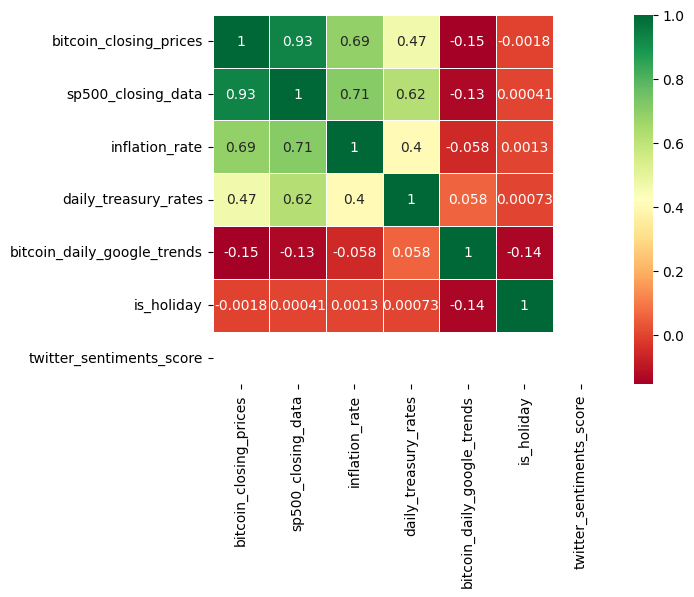

In [22]:
# Example: Plotting a heatmap to show feature correlations

corr = df.corr()
sns.heatmap(corr, cmap='RdYlGn', annot=True, linewidths=0.5)
print(corr.map(nf_2))
plt.show()


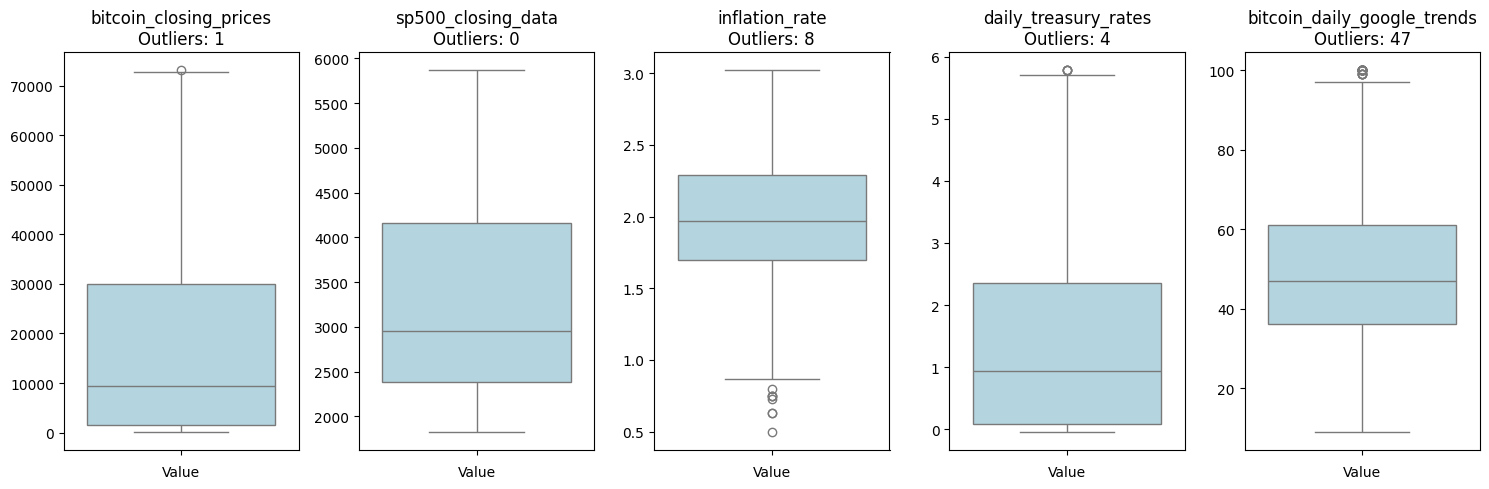

In [23]:
# Function to detect outliers using the IQR method
def detect_outliers_iqr(data):
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return ((data < lower_bound) | (data > upper_bound))

# Set up the plot grid (3x3 layout)
fig, axes = plt.subplots(1, 5, figsize=(15, 5))
axes = axes.flatten()

# Generate boxplots for each numeric column
for i, col in enumerate(variables):
    ax = axes[i]
    valid_data = df[col].dropna()  # Drop missing values
    sns.boxplot(y=valid_data, ax=ax, color='lightblue')  # Pass clean data

    # Detect and count outliers for the current column
    outliers = detect_outliers_iqr(df[col])  # Pass the individual column
    num_outliers = outliers.sum()

    # Annotate the plot with the number of outliers
    ax.set_title(f"{col}\nOutliers: {num_outliers}", fontsize=12)
    ax.set_xlabel('Value')
    ax.set_ylabel('')

# Hide unused subplots if columns < 9
for j in range(len(variables), len(axes)):
    fig.delaxes(axes[j])

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

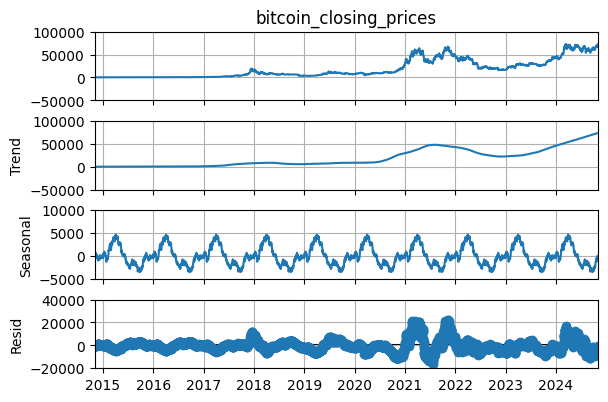

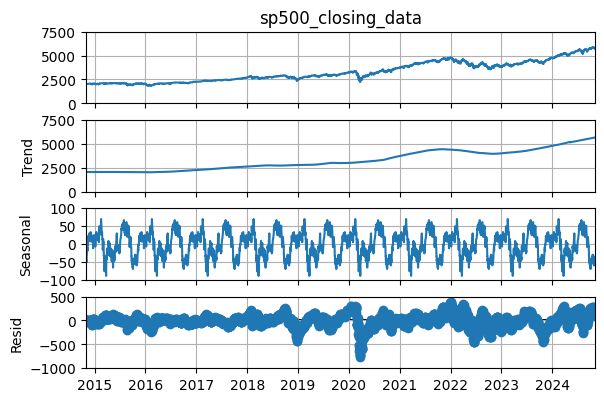

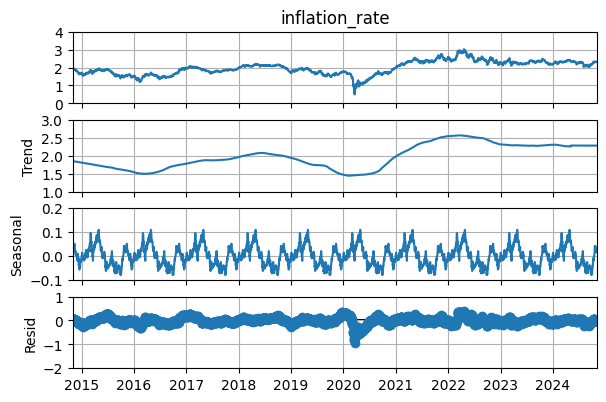

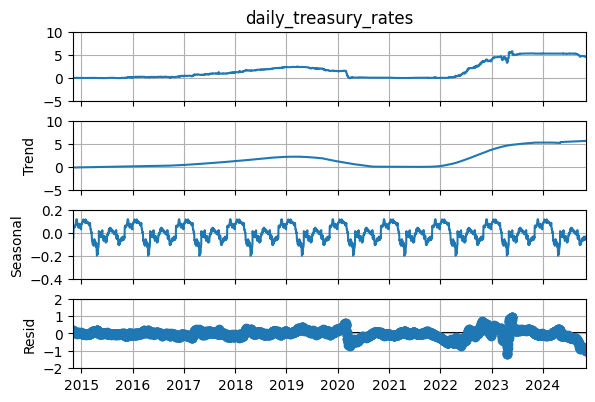

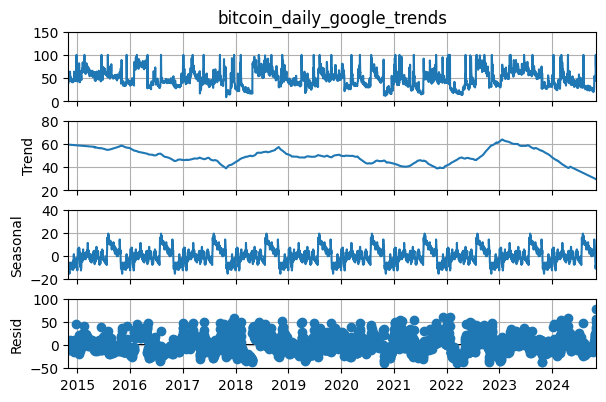

In [24]:
# Specify the period (assumes daily data with yearly seasonality, adjust as needed)
period = 365

# Initialize an empty dictionary to store residuals
residuals_dict = {}

# Iterate through each column to perform seasonal decomposition
for col in variables:
    
    # Perform seasonal decomposition (using additive model, as Multiplicative seasonality is not 
    #                                 appropriate for zero and negative values)
    result = seasonal_decompose(df[col], model='additive', period=period, extrapolate_trend='freq')

    # Plot the decomposition
    fig = result.plot()
    fig.set_size_inches(6, 4)  # Adjust figure size
    
    # Get the axes from the figure
    axes = fig.get_axes()

    # Iterate over each subplot axis (observed, trend, seasonal, residual)
    for ax in axes:
        ax.grid(True)  # Enable gridlines for all subplots
        ax.set_yticks(ax.get_yticks())  # Show y-ticks

# Remove empty subplots if there are fewer than 8 variables
for j in range(len(variables), len(axes)):
    fig.delaxes(axes[j])

# Display the plot
plt.show()

Shapiro-Wilk Test for bitcoin_closing_prices - Statistic: 0.9197, p-value: 1.00e-38, Dist: not normal
Shapiro-Wilk Test for sp500_closing_data - Statistic: 0.9538, p-value: 4.44e-31, Dist: not normal
Shapiro-Wilk Test for inflation_rate - Statistic: 0.9455, p-value: 2.92e-33, Dist: not normal
Shapiro-Wilk Test for daily_treasury_rates - Statistic: 0.9453, p-value: 2.59e-33, Dist: not normal
Shapiro-Wilk Test for bitcoin_daily_google_trends - Statistic: 0.9807, p-value: 9.67e-21, Dist: not normal


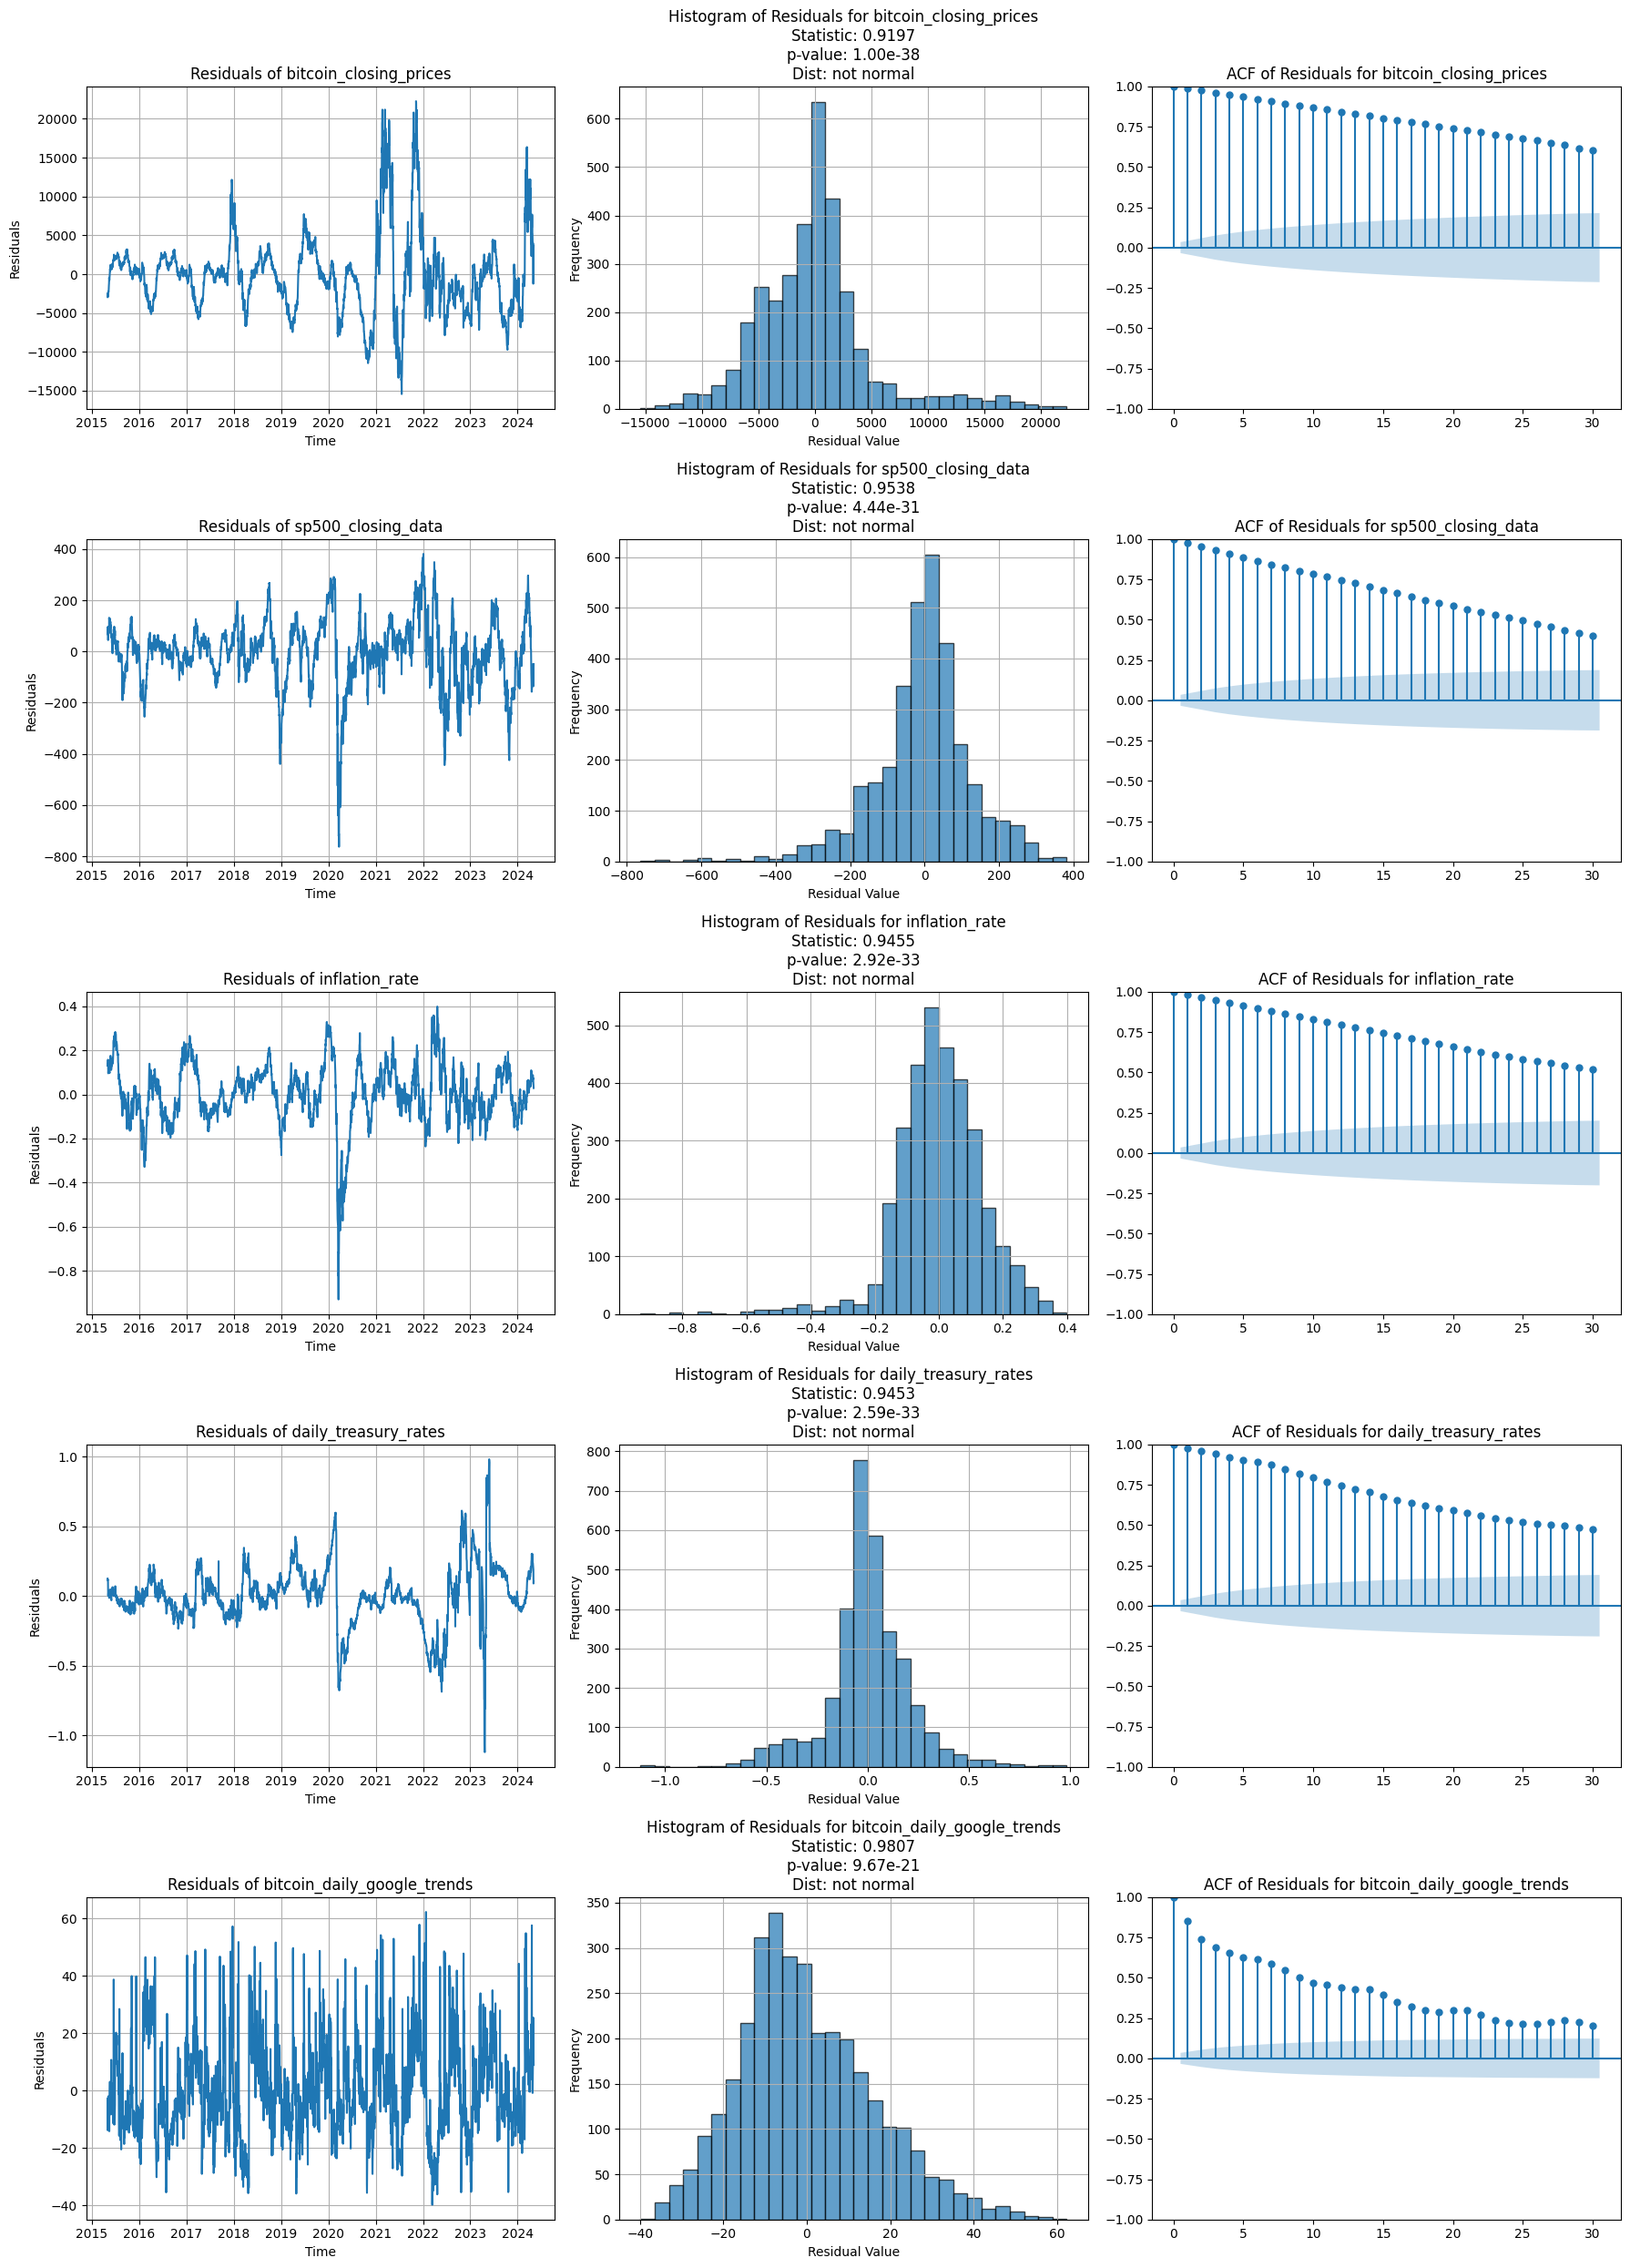

In [25]:
# Set the number of subplots (3 columns: residuals plot, histogram, ACF, 1 row for each variable)
n_cols = 3
n_rows = len(variables)  # Number of rows will be equal to the number of variables

# Create subplots for each variable (3 plots in each row)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 5 * n_rows))
axes = axes.flatten()

# Loop through each column
for i, col in enumerate(variables):
    # Decompose the time series for the current column
    decomposition = seasonal_decompose(df[col], model='additive', period=365)  # Period=365 assuming daily data with yearly seasonality
    
    # Extract residuals
    residuals = decomposition.resid.dropna()  # Drop NA for cleaner residuals

    # Plot residuals over time (first plot in the row)
    axes[i * 3].plot(residuals)
    axes[i * 3].set_title(f'Residuals of {col}')
    axes[i * 3].set_xlabel('Time')
    axes[i * 3].set_ylabel('Residuals')
    axes[i * 3].grid(True)

    # Perform Shapiro-Wilk test for normality
    stat, p_value = shapiro(residuals)  # Use scipy.stats.shapiro
    normality = "normal" if p_value > 0.05 else "not normal"

    # Format the p-value in scientific notation
    p_value_scientific = "{:.2e}".format(p_value)
    stat_rounded = "{:.4f}".format(stat)  # Format the statistic with 4 decimal places

    # Plot histogram of residuals (second plot in the row)
    axes[i * 3 + 1].hist(residuals, bins=30, edgecolor='black', alpha=0.7)
    axes[i * 3 + 1].set_title(f'Histogram of Residuals for {col}\nStatistic: {stat_rounded}\np-value: {p_value_scientific}\nDist: {normality}')
    axes[i * 3 + 1].set_xlabel('Residual Value')
    axes[i * 3 + 1].set_ylabel('Frequency')
    axes[i * 3 + 1].grid(True)

    # Plot ACF of residuals (third plot in the row)
    plot_acf(residuals, lags=30, ax=axes[i * 3 + 2])
    axes[i * 3 + 2].set_title(f'ACF of Residuals for {col}')
    
    print(f"Shapiro-Wilk Test for {col} - Statistic: {stat_rounded}, p-value: {p_value_scientific}, Dist: {normality}")

# Adjust layout for better spacing between plots
plt.tight_layout()
plt.show()

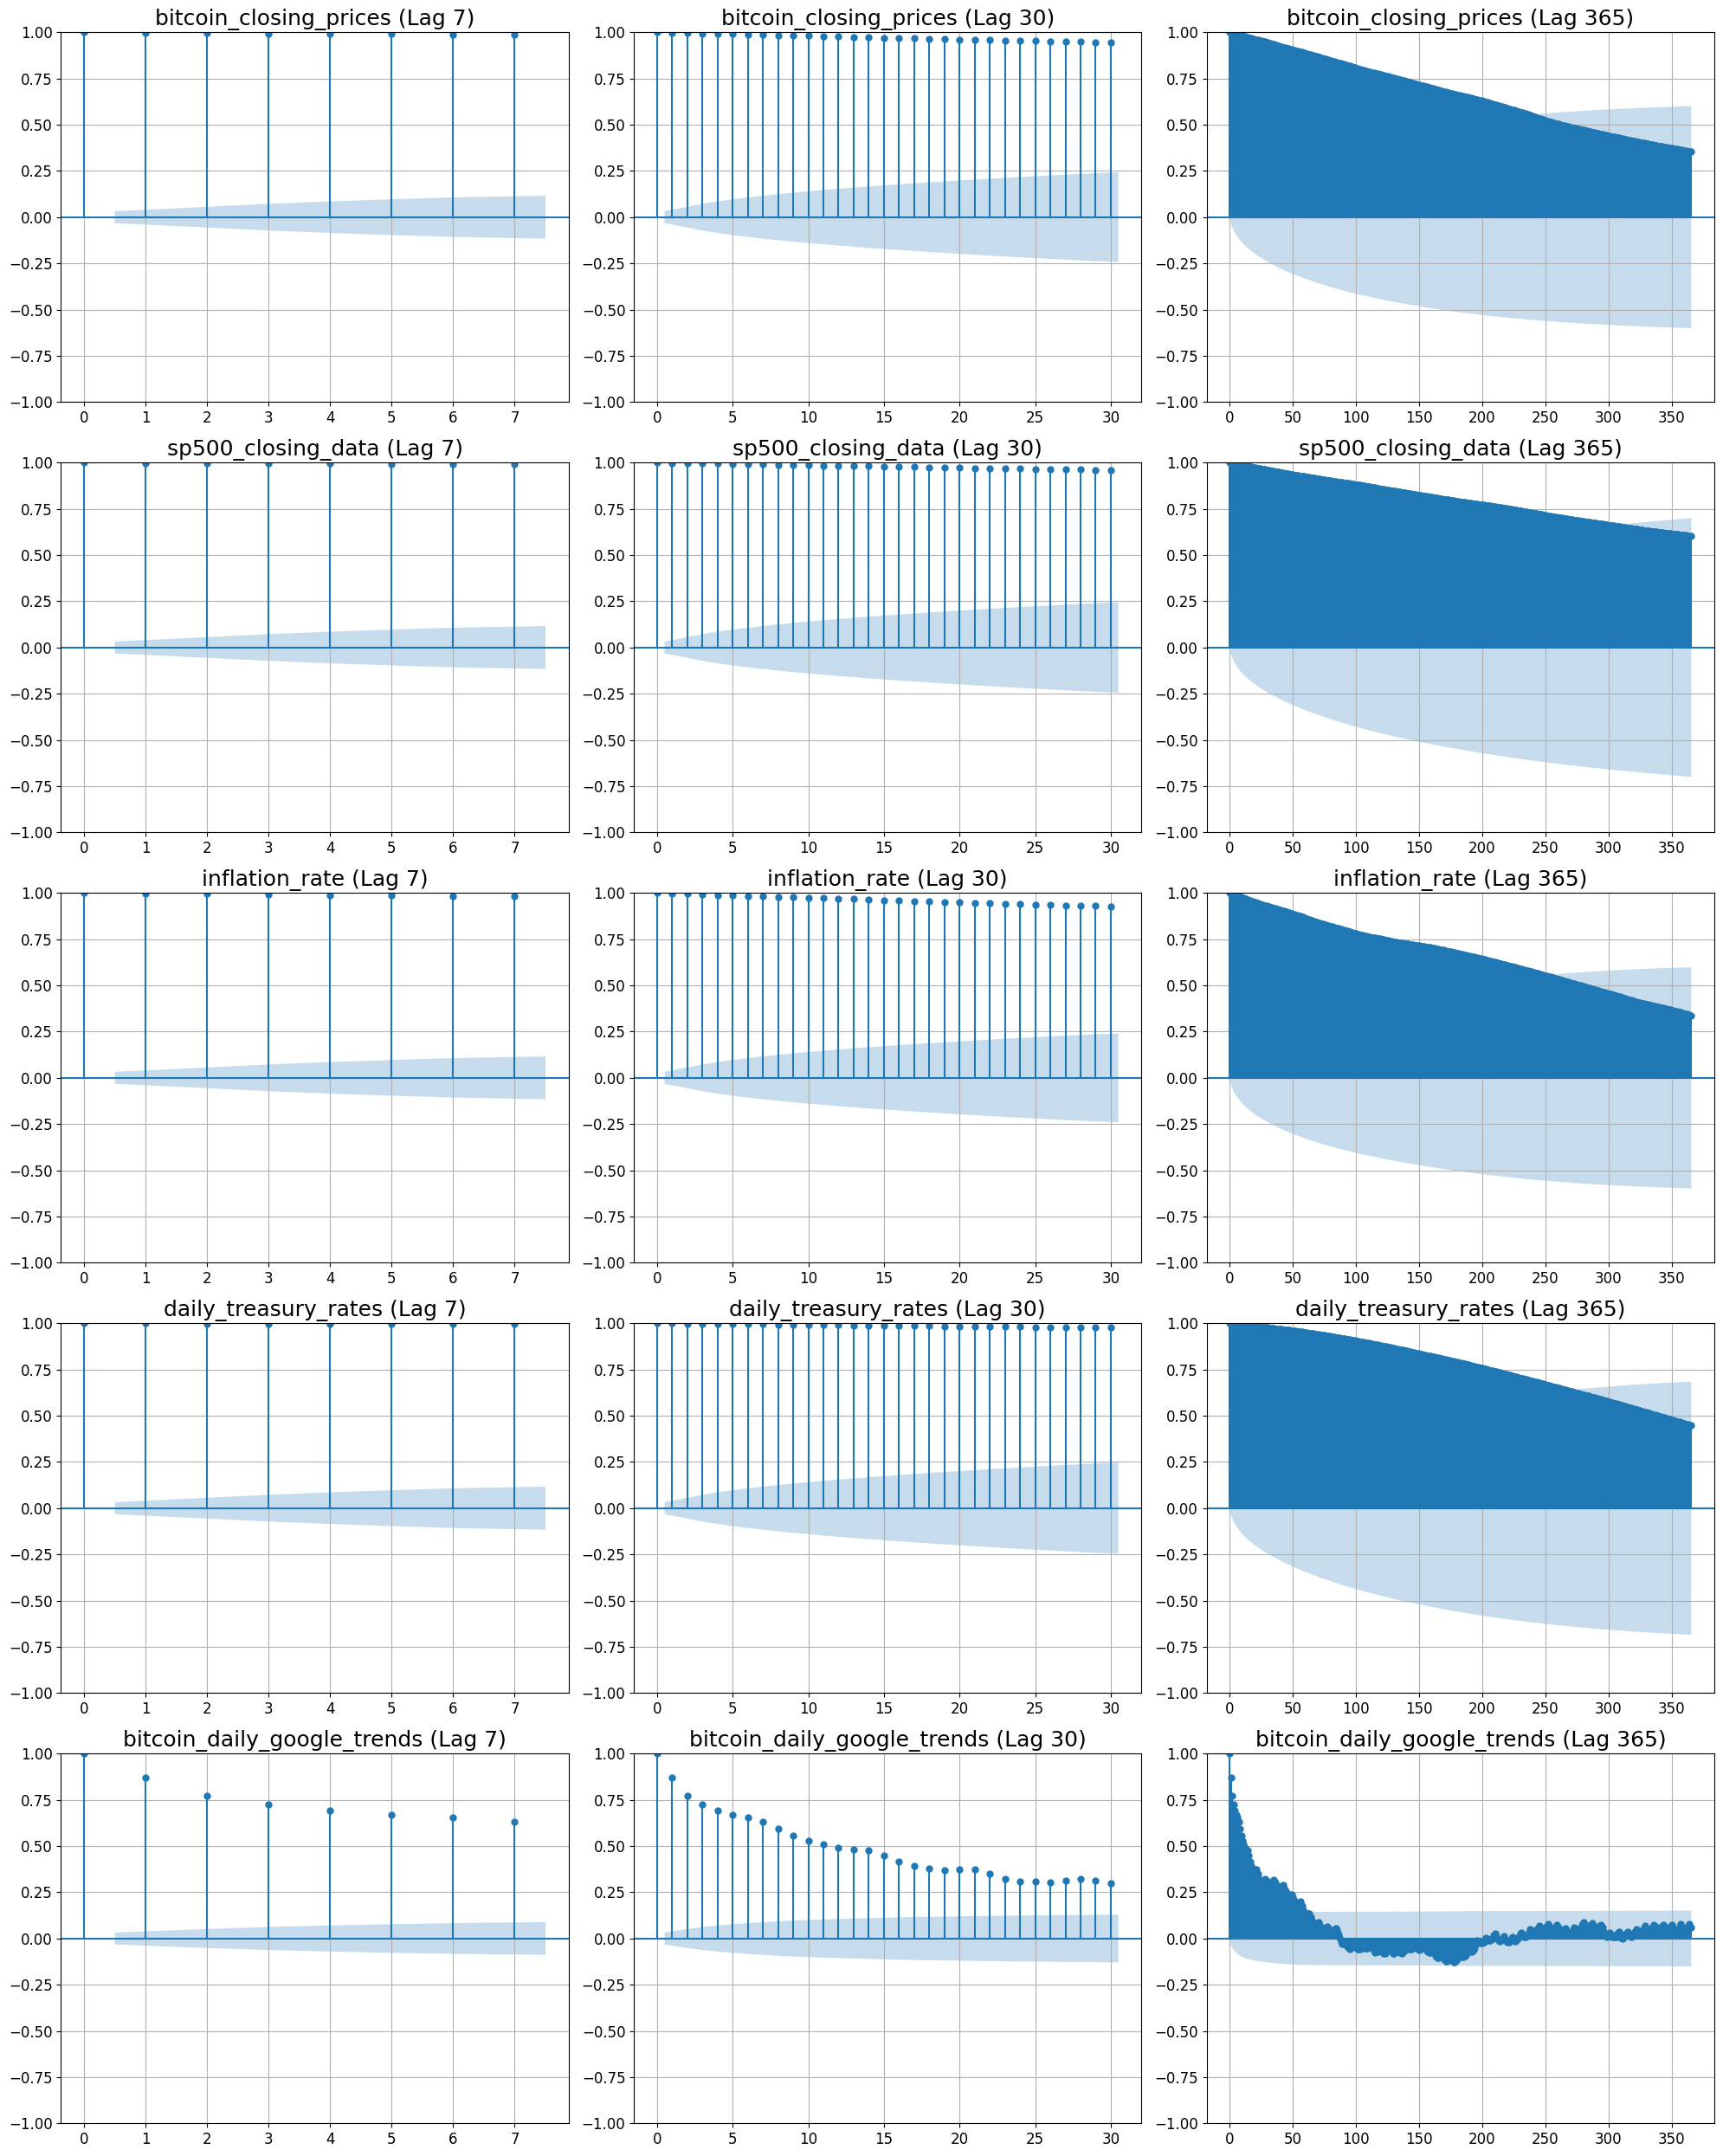

In [26]:
# Create a figure with subplots (4 rows and 3 columns for 8 variables)
fig, axes = plt.subplots(nrows=len(variables), ncols=3, figsize=(20, len(variables)*5))
axes = axes.flatten()  # Flatten the axes array for easier indexing

# Define the lags for weekly, monthly, and yearly seasonality
lags_list = [7, 30, 365]  # lags corresponding to weekly, monthly, and yearly

# Iterate through each variable and plot its ACF for the specified lags
for i, col in enumerate(variables):
    for j, lag in enumerate(lags_list):
        # Plot ACF for each variable at the given lag
        plot_acf(df[col], lags=lag, ax=axes[i*3 + j])  # Calculate ACF for current lag
        axes[i*3 + j].set_title(f"{col} (Lag {lag})", fontsize=18)  # Increase axis title font size
        axes[i*3 + j].grid(True)

        # Increase font size of x and y ticks
        axes[i*3 + j].tick_params(axis='both', which='major', labelsize=12)  # x and y ticks font size

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

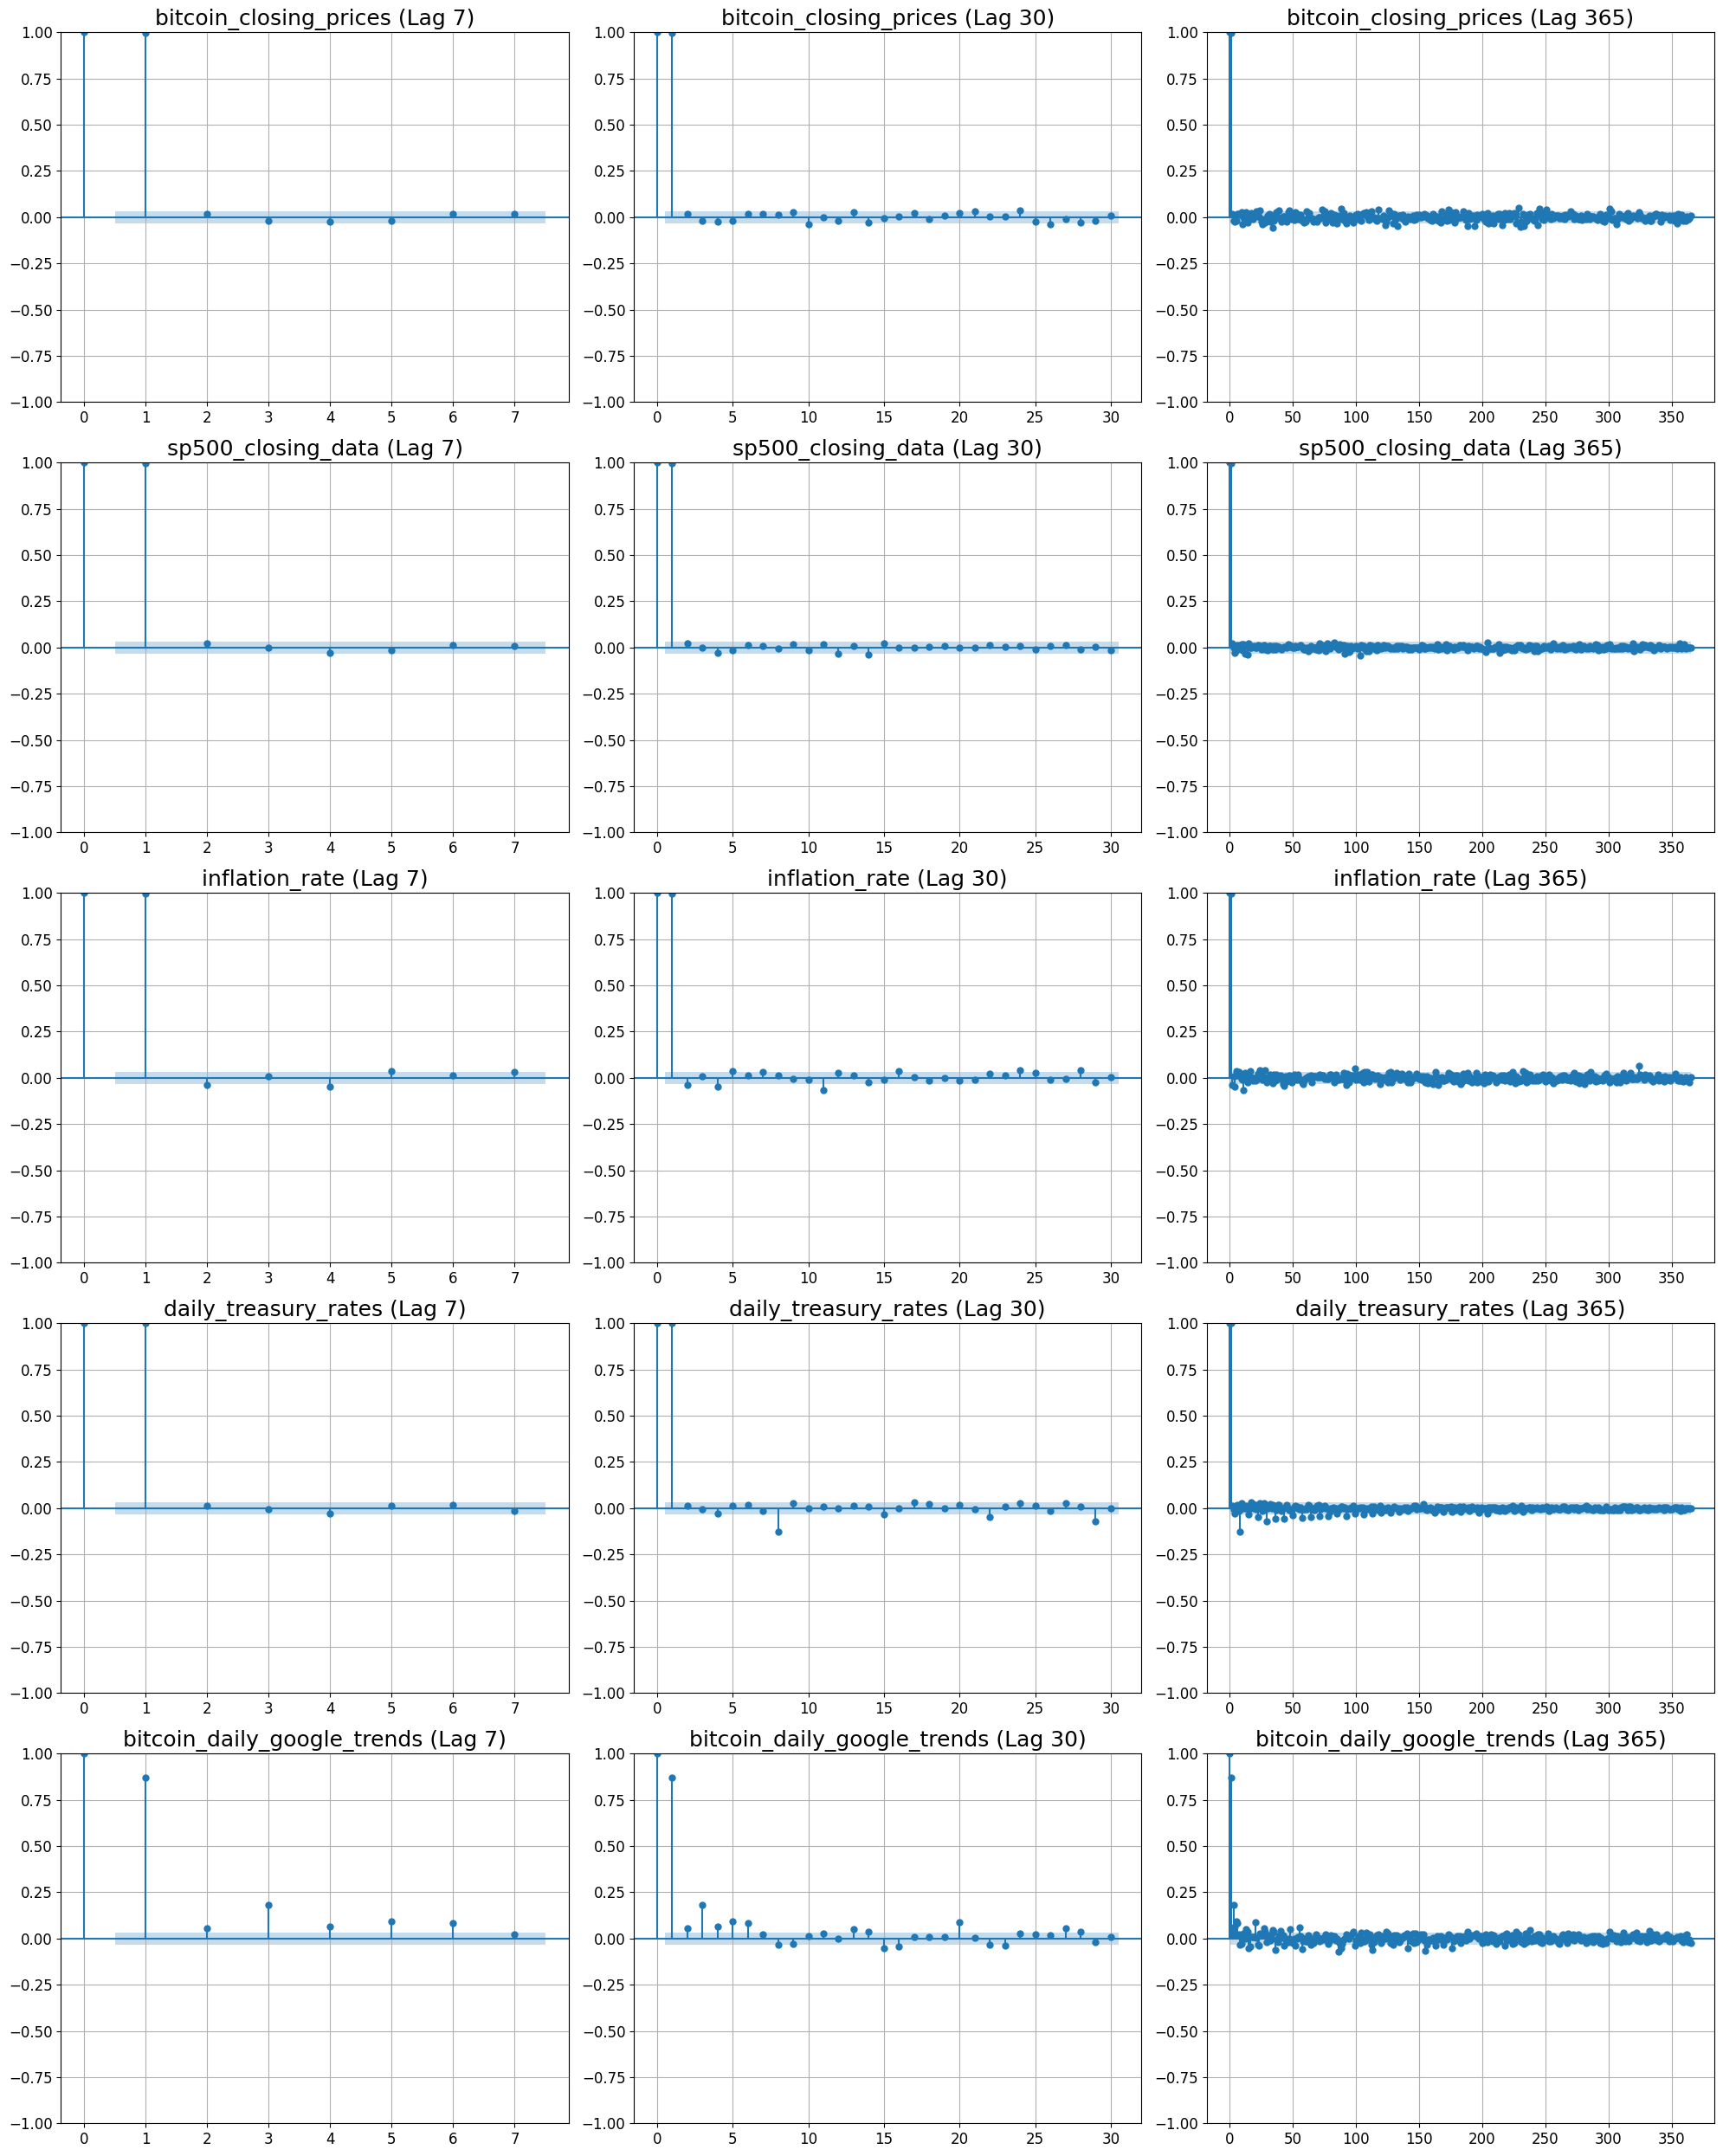

In [27]:
# Create a figure with subplots (4 rows and 3 columns for each variable's PACF)
fig, axes = plt.subplots(nrows=len(variables), ncols=3, figsize=(20, len(variables)*5))
axes = axes.flatten()  # Flatten the axes array for easier indexing

# Define the lags for weekly, monthly, and yearly seasonality
lags_list = [7, 30, 365]  # lags corresponding to weekly, monthly, and yearly

# Iterate through each variable and plot its PACF for the specified lags
for i, col in enumerate(variables):
    for j, lag in enumerate(lags_list):
        # Plot PACF for each variable at the given lag
        plot_pacf(df[col], lags=lag, ax=axes[i*3 + j])  # Calculate PACF for current lag
        axes[i*3 + j].set_title(f"{col} (Lag {lag})", fontsize=18)  # Increase axis title font size
        axes[i*3 + j].grid(True)

        # Increase font size of x and y ticks
        axes[i*3 + j].tick_params(axis='both', which='major', labelsize=12)  # x and y ticks font size

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

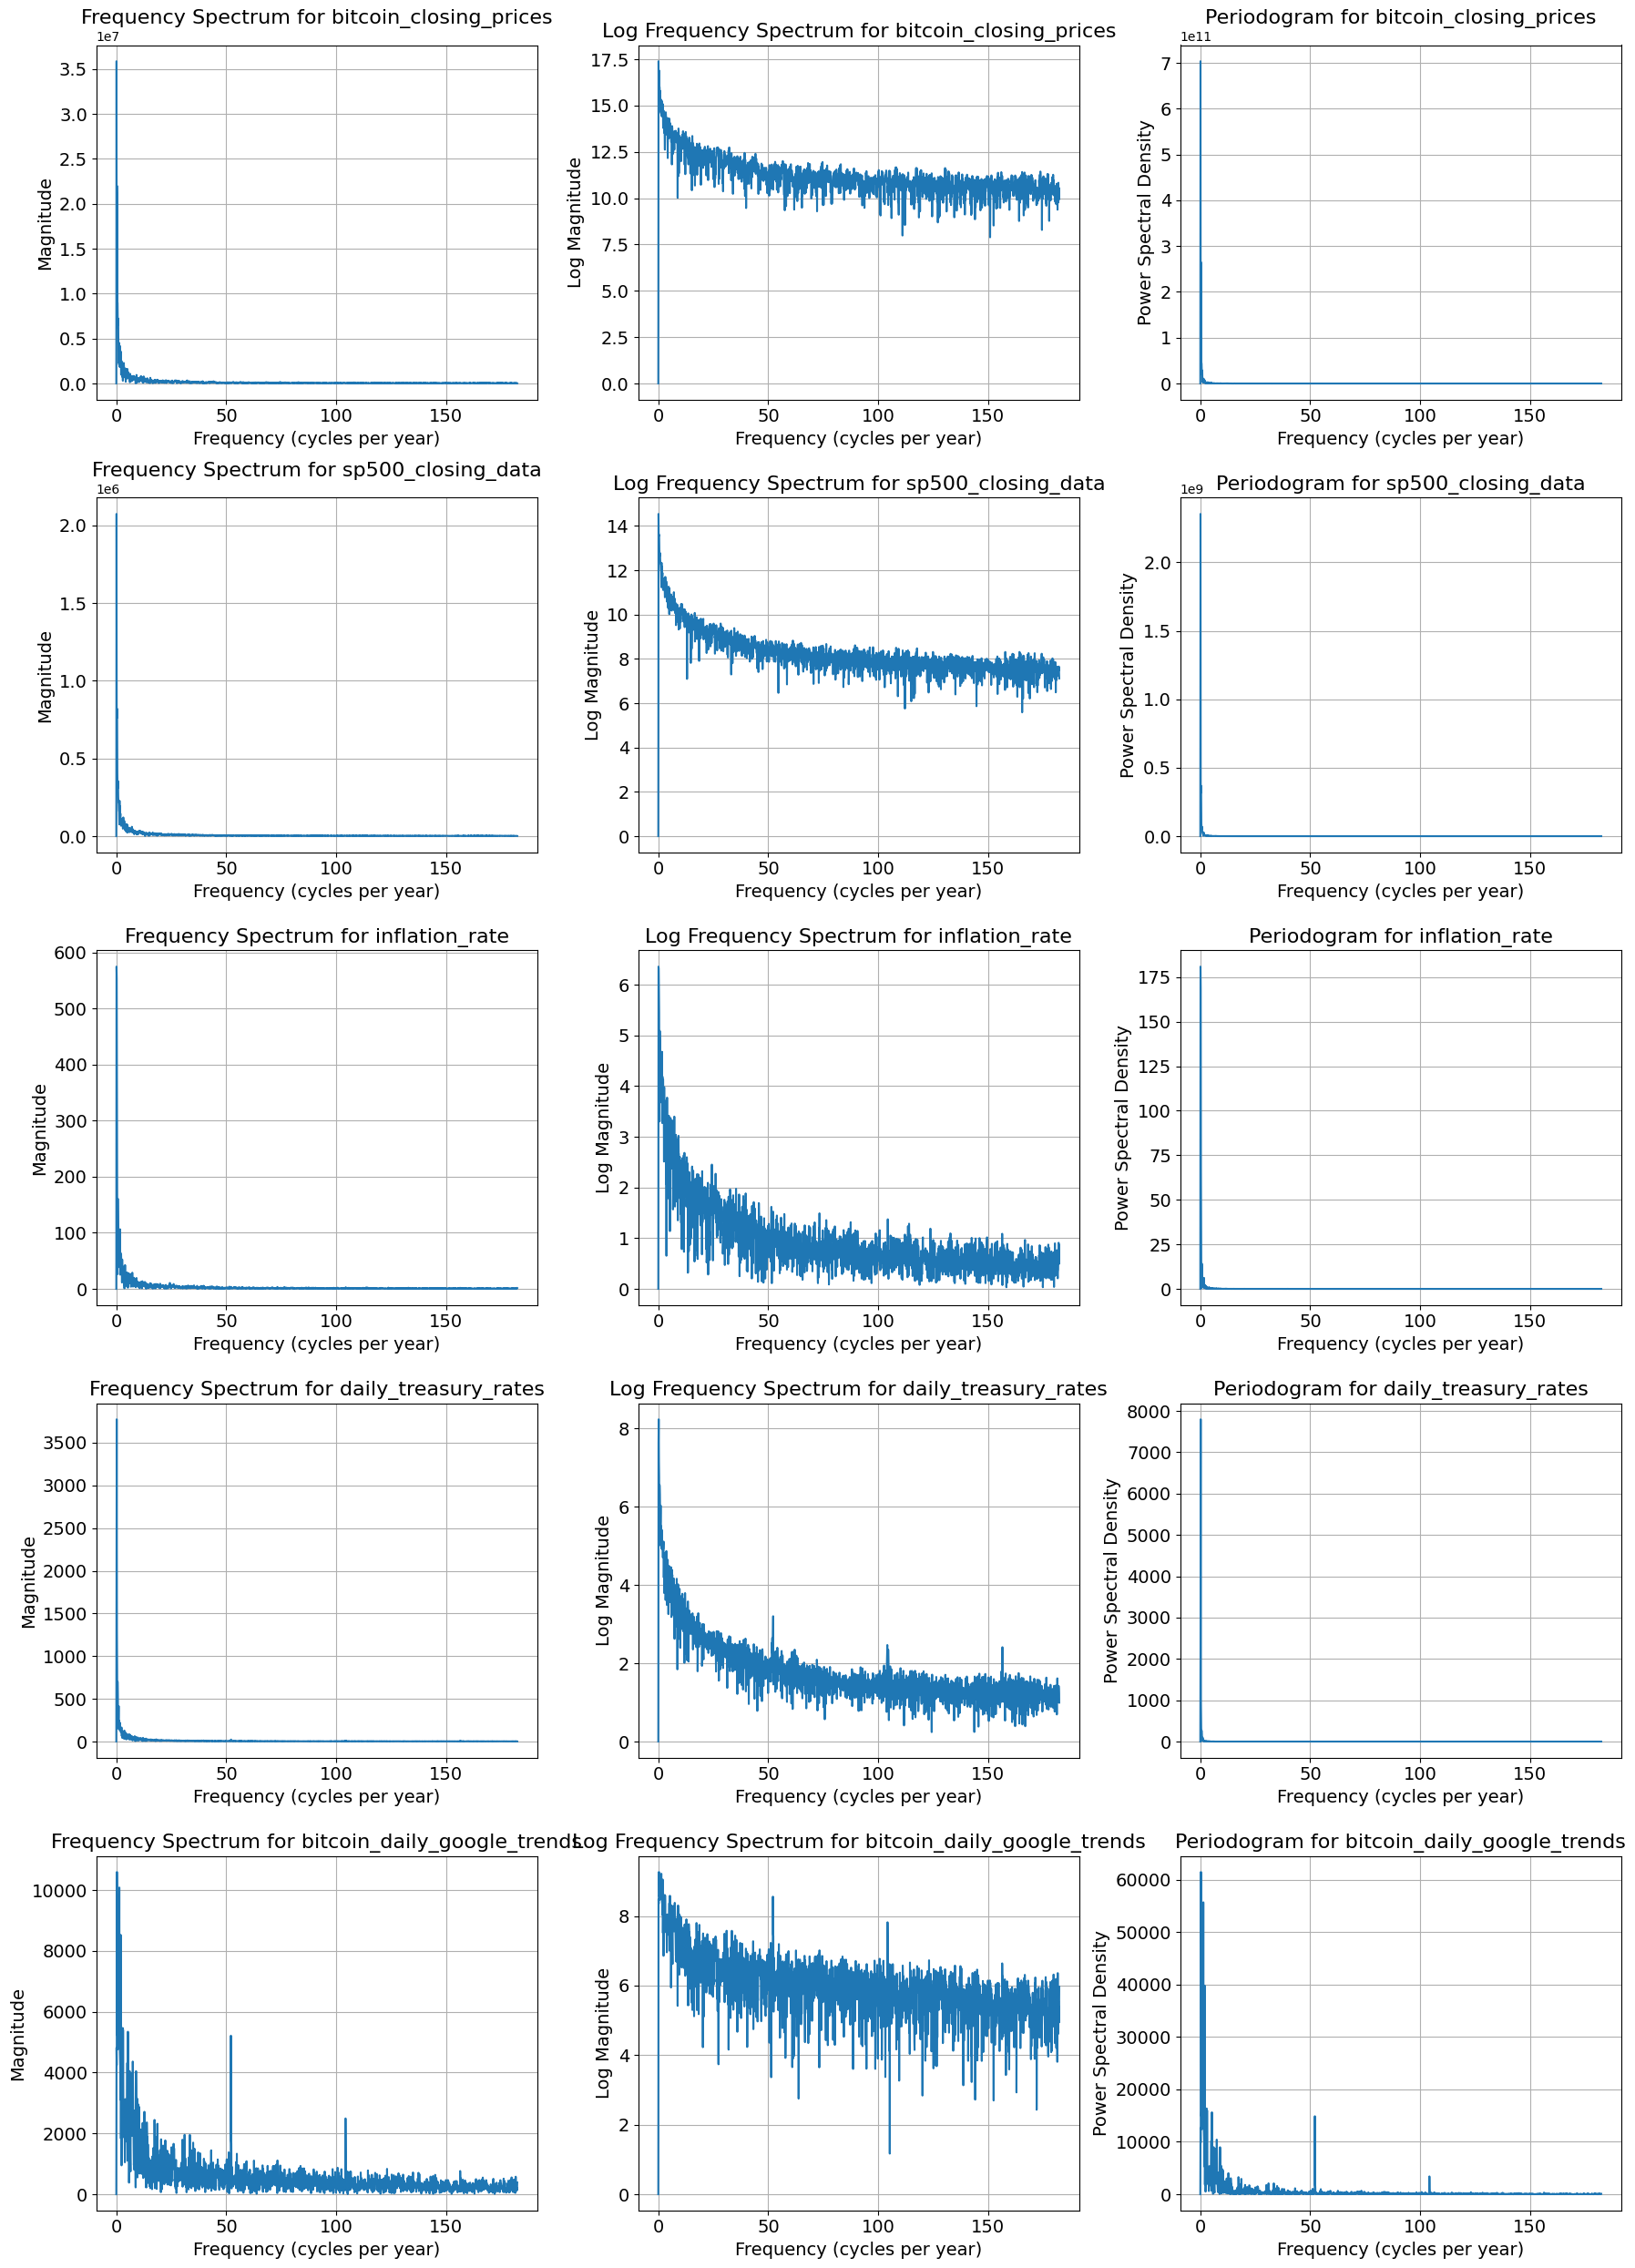

In [28]:
# Set up the figure and grid
n_cols = 3  # 3 plots per row (Frequency Spectrum, Log Frequency Spectrum, and Periodogram)
n_rows = len(variables)  # One row for each variable
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(18, len(variables) * 5))

# Flatten axes array for easier indexing
axes = axes.flatten()

# Loop through each variable and compute the required plots
for i, var in enumerate(variables):
    # Extract data and drop missing values
    data = df[var].dropna()
    
    # Subtract mean to center the data
    data_centered = data - data.mean()
    
    # Perform Fourier Transform
    fft_result = np.fft.fft(data_centered)
    
    # Calculate corresponding frequencies
    freqs = np.fft.fftfreq(len(data_centered), d=1)  # d=1 assumes daily data
    
    # Convert frequency to cycles per year
    freqs_per_year = freqs * 365  # Multiply by 365 to convert to frequency per year
    
    # Get magnitude of the FFT
    magnitude = np.abs(fft_result)
    
    # Plot Frequency Spectrum
    axes[i * 3].plot(freqs_per_year[:len(freqs)//2], magnitude[:len(freqs)//2])  # Only positive frequencies
    axes[i * 3].set_title(f'Frequency Spectrum for {var}', fontsize=16)
    axes[i * 3].set_xlabel('Frequency (cycles per year)', fontsize=14)
    axes[i * 3].set_ylabel('Magnitude', fontsize=14)
    axes[i * 3].tick_params(axis='both', labelsize=14)  # Set x and y tick labels font size
    axes[i * 3].grid(True)

    # Apply log transformation to magnitudes for Log Frequency Spectrum
    magnitude_log = np.log1p(magnitude[:len(freqs)//2])  # log1p to handle 0 safely
    
    # Plot Log Frequency Spectrum
    axes[i * 3 + 1].plot(freqs_per_year[:len(freqs)//2], magnitude_log)
    axes[i * 3 + 1].set_title(f'Log Frequency Spectrum for {var}', fontsize=16)
    axes[i * 3 + 1].set_xlabel('Frequency (cycles per year)', fontsize=14)
    axes[i * 3 + 1].set_ylabel('Log Magnitude', fontsize=14)
    axes[i * 3 + 1].tick_params(axis='both', labelsize=14)  # Set x and y tick labels font size
    axes[i * 3 + 1].grid(True)

    # Calculate frequencies and power spectral density for Periodogram
    freqs, power = periodogram(data, fs=1)  # fs=1 assumes daily sampling
    
    # Convert periodogram frequency to cycles per year
    freqs_per_year_periodogram = freqs * 365  # Multiply by 365 to convert to frequency per year
    
    # Plot Periodogram
    axes[i * 3 + 2].plot(freqs_per_year_periodogram, power)
    axes[i * 3 + 2].set_title(f"Periodogram for {var}", fontsize=16)
    axes[i * 3 + 2].set_xlabel("Frequency (cycles per year)", fontsize=14)
    axes[i * 3 + 2].set_ylabel("Power Spectral Density", fontsize=14)
    axes[i * 3 + 2].tick_params(axis='both', labelsize=14)  # Set x and y tick labels font size
    axes[i * 3 + 2].grid(True)

# Adjust layout to avoid overlap and display
plt.tight_layout()
plt.show()

In [29]:
# Initialize an empty list to store results
adf_results = {}

# Loop through each variable in the DataFrame
for col in variables:
    # Perform Dickey-Fuller test
    dftest = adfuller(df[col], autolag='AIC')

    # Collect all the results from the ADF test
    adf_results[col] = {
        'Test Stats': dftest[0],  # ADF Test Statistic
        'p-value': dftest[1],  # p-value of the test
        'Number of Lags': dftest[2],  # Number of lags used in the test
        'Number of Used Observations': dftest[3],  # Number of observations used
        'Critical Value (1%)': dftest[4]['1%'],  # Critical value for 1% significance level
        'Critical Value (5%)': dftest[4]['5%'],  # Critical value for 5% significance level
        'Critical Value (10%)': dftest[4]['10%'],  # Critical value for 10% significance level
        'H0 Decision': 'Reject' if dftest[1] < 0.05 else 'Accept',  # H0 decision based on p-value
        'Stationary': 'Yes' if dftest[1] < 0.05 else 'No'  # Stationarity based on p-value
    }

# Convert the dictionary into a DataFrame
adf_results_df = pd.DataFrame(adf_results)

# Display the result table
print(adf_results_df)

                            bitcoin_closing_prices sp500_closing_data inflation_rate daily_treasury_rates bitcoin_daily_google_trends
Test Stats                        -0.618348             0.368779        -1.988891         -0.282852                -6.015863         
p-value                            0.866782             0.980289         0.291465          0.927898                      0.0         
Number of Lags                           28                   14               15                29                       27         
Number of Used Observations            3626                 3640             3639              3625                     3627         
Critical Value (1%)               -3.432155            -3.432148        -3.432148         -3.432155                -3.432154         
Critical Value (5%)               -2.862337            -2.862334        -2.862335         -2.862338                -2.862337         
Critical Value (10%)              -2.567194            -2.5671

In [30]:
# Initialize an empty list to store results
kpss_results = {}

# Loop through each variable in the DataFrame
for col in variables:
    # Perform KPSS test
    kpsstest = kpss(df[col], regression='c', nlags='auto')  # 'c' for level stationarity

    # Collect all the results from the KPSS test
    kpss_results[col] = {
        'Test Stats': kpsstest[0],  # KPSS Test Statistic
        'p-value': kpsstest[1],  # p-value of the test
        'Number of Lags': kpsstest[2],  # Number of lags used in the test
        'Critical Value (10%)': kpsstest[3]['10%'],  # Critical value for 10% significance level
        'Critical Value (5%)': kpsstest[3]['5%'],  # Critical value for 5% significance level
        'Critical Value (1%)': kpsstest[3]['1%'],  # Critical value for 1% significance level
        'H0 Decision': 'Reject' if kpsstest[1] < 0.05 else 'Accept',  # H0 decision based on p-value
        'Stationary': 'No' if kpsstest[1] < 0.05 else 'Yes'  # Stationarity based on p-value
    }

# Convert the dictionary into a DataFrame
kpss_results_df = pd.DataFrame(kpss_results)

# Display the result table
print(kpss_results_df)

                     bitcoin_closing_prices sp500_closing_data inflation_rate daily_treasury_rates bitcoin_daily_google_trends
Test Stats                  6.581981             8.700938         4.354018          4.628924                 0.248662         
p-value                         0.01                 0.01             0.01              0.01                      0.1         
Number of Lags                    38                   38               38                38                       36         
Critical Value (10%)           0.347                0.347            0.347             0.347                    0.347         
Critical Value (5%)            0.463                0.463            0.463             0.463                    0.463         
Critical Value (1%)            0.739                0.739            0.739             0.739                    0.739         
H0 Decision                   Reject               Reject           Reject            Reject                   

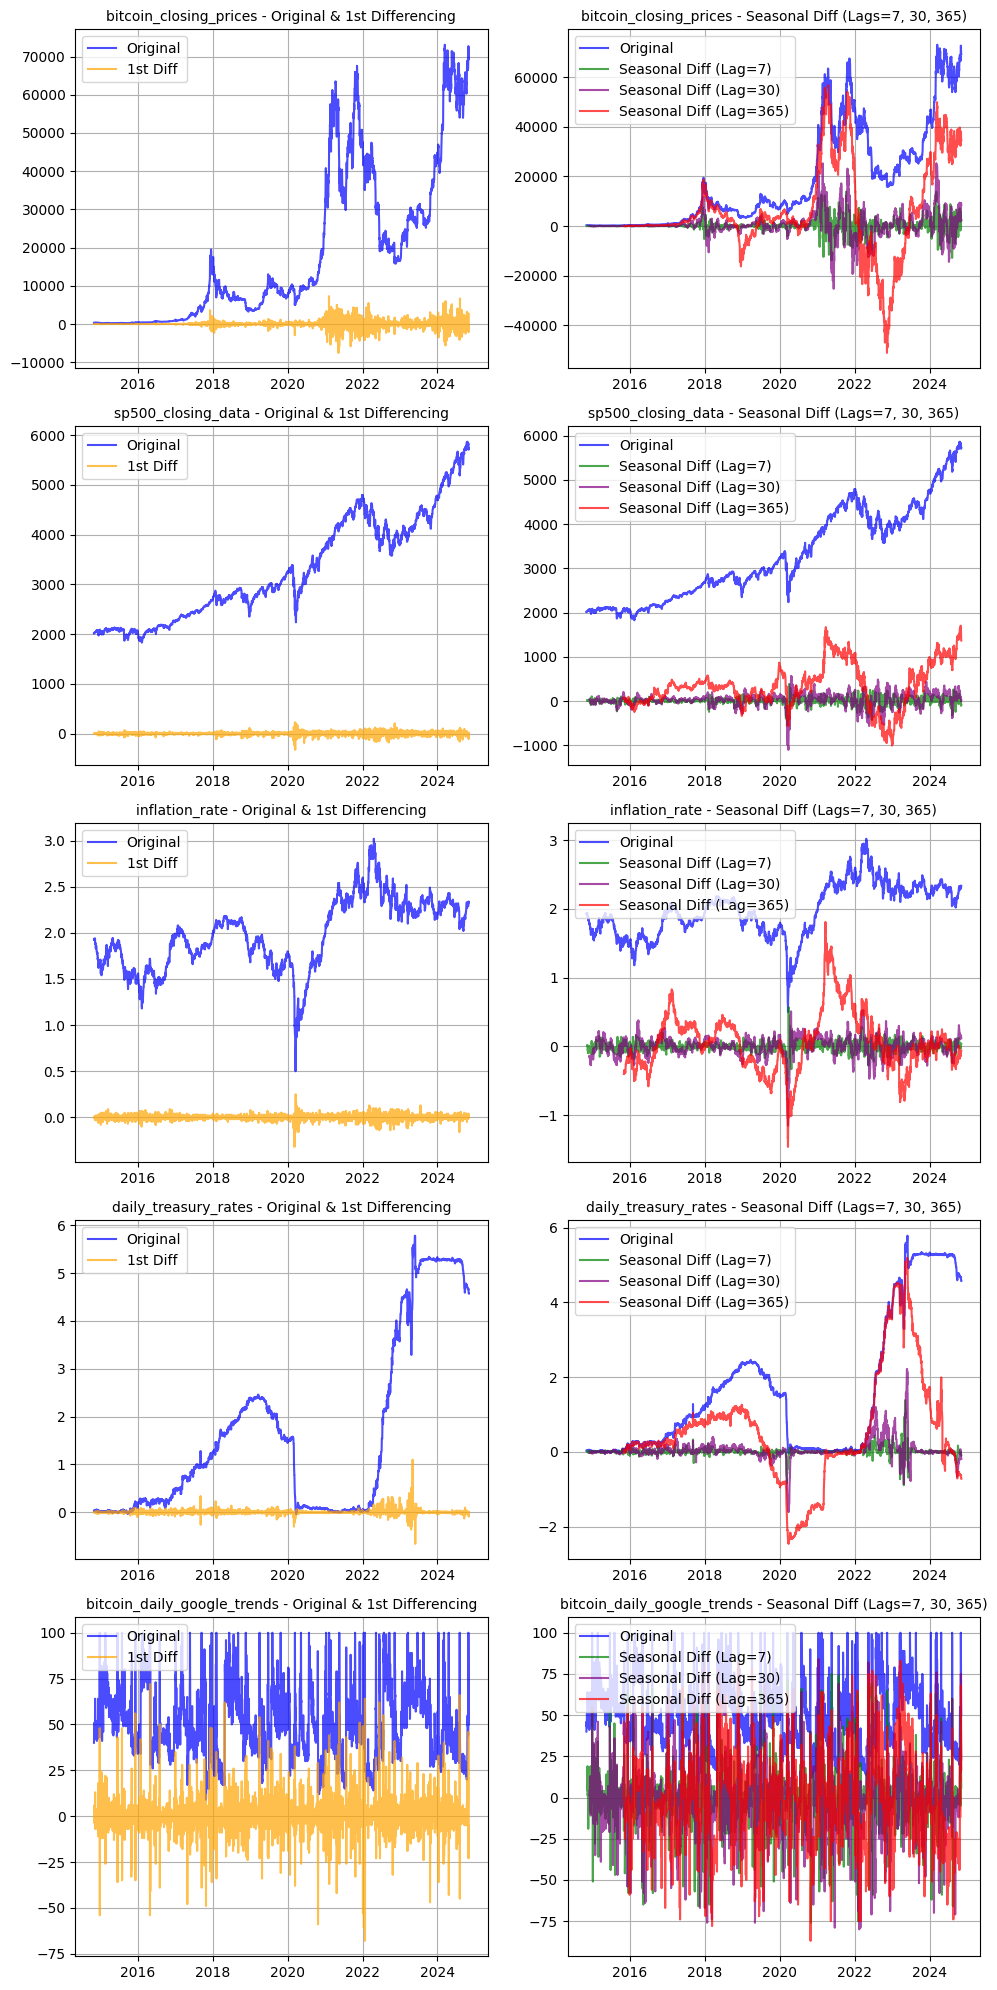

In [31]:
# Create a function to plot differencing and seasonal differencing for multiple lags
def plot_differencing(df, variables, seasonal_lags):
    n_cols = 2
    n_rows = len(variables)
    fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(10, 20))
    
    for i, var in enumerate(variables):
        data = df[var].dropna()
        
        # Perform first differencing
        diff_1 = data.diff().dropna()
        
        # Perform seasonal differencing for each lag (7, 30, 365)
        diff_seasonal_7 = data.diff(7).dropna()
        diff_seasonal_30 = data.diff(30).dropna()
        diff_seasonal_365 = data.diff(365).dropna()
        
        # Plot original data and 1st differencing
        axes[i, 0].plot(data, label='Original', color='blue', alpha=0.7)
        axes[i, 0].plot(diff_1, label='1st Diff', color='orange', alpha=0.7)
        axes[i, 0].set_title(f"{var} - Original & 1st Differencing", fontsize=10)
        axes[i, 0].legend(loc='upper left')
        axes[i, 0].grid()
        
        # Plot seasonal differencing for multiple lags (7, 30, 365)
        axes[i, 1].plot(data, label='Original', color='blue', alpha=0.7)
        axes[i, 1].plot(diff_seasonal_7, label='Seasonal Diff (Lag=7)', color='green', alpha=0.7)
        axes[i, 1].plot(diff_seasonal_30, label='Seasonal Diff (Lag=30)', color='purple', alpha=0.7)
        axes[i, 1].plot(diff_seasonal_365, label='Seasonal Diff (Lag=365)', color='red', alpha=0.7)
        axes[i, 1].set_title(f"{var} - Seasonal Diff (Lags=7, 30, 365)", fontsize=10)
        axes[i, 1].legend(loc='upper left')
        axes[i, 1].grid()

    plt.tight_layout()
    plt.show()

# Define seasonal lags to consider
seasonal_lags = [7, 30, 365]  # Lags for weekly, monthly, and yearly seasonality

# Plot differencing for all variables with the defined seasonal lags
plot_differencing(df, variables, seasonal_lags)

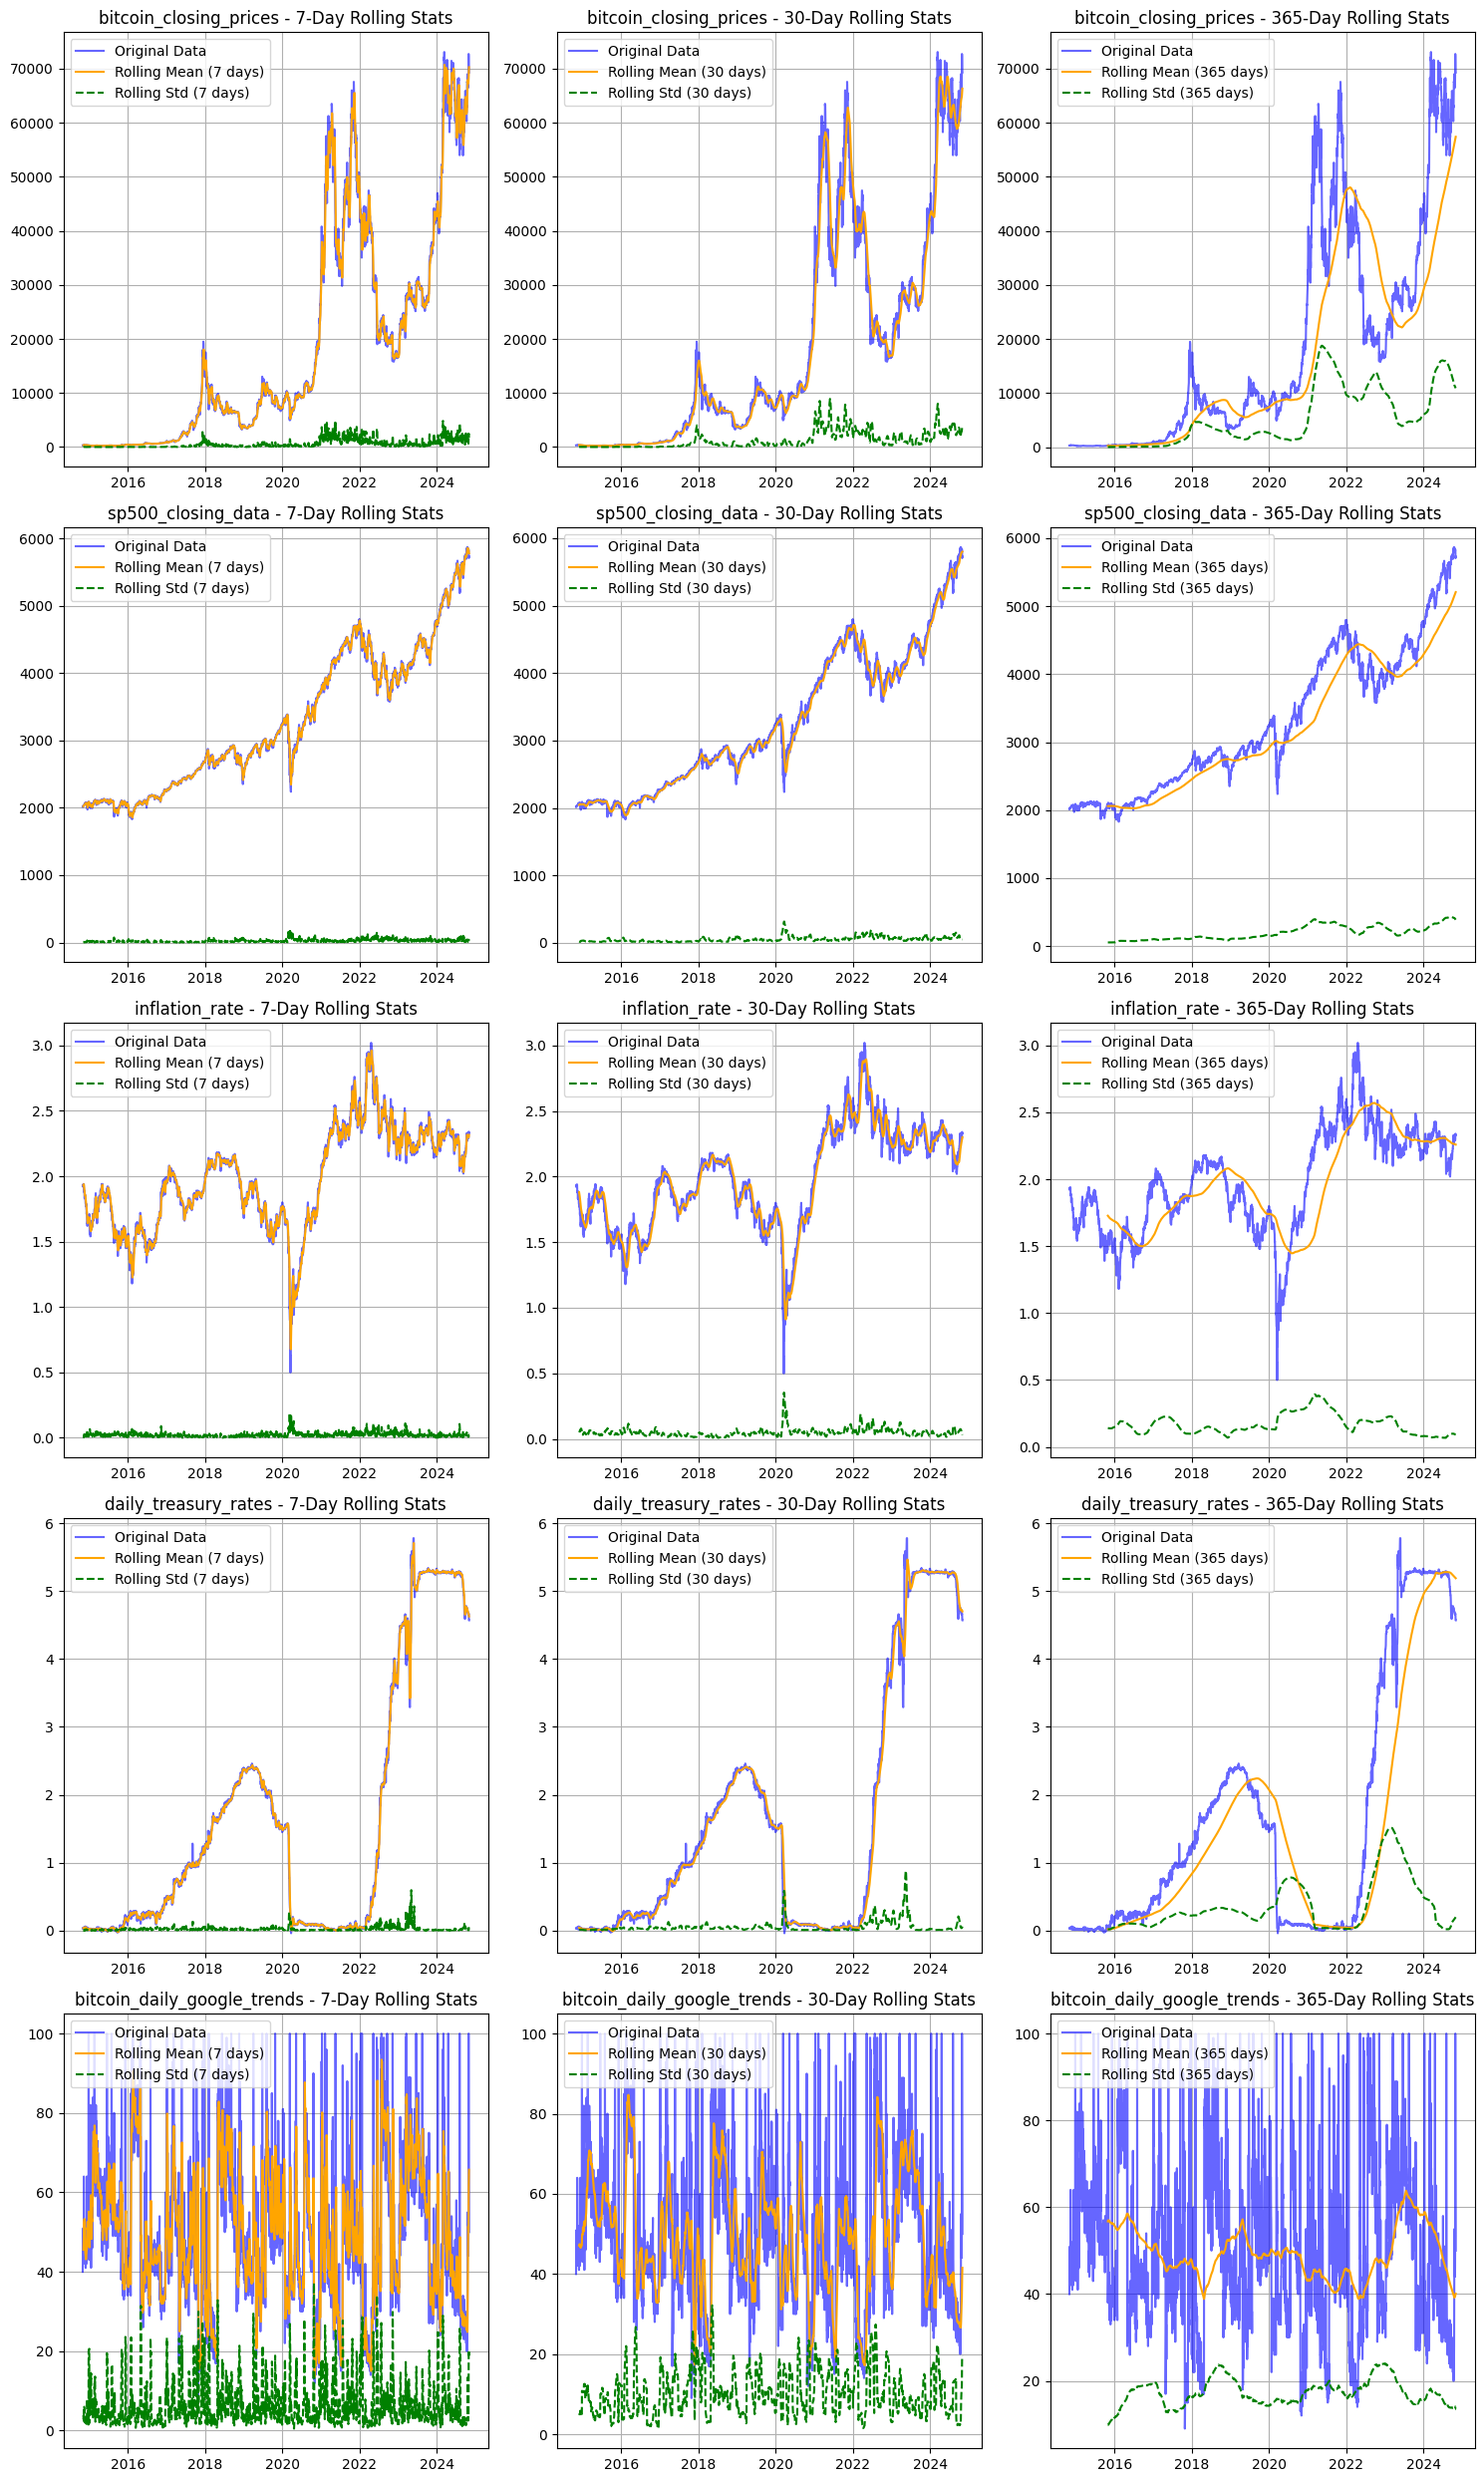

In [32]:
# Function to plot rolling statistics
def plot_rolling_stats(df, variables, windows):
    n_cols = len(windows)
    n_rows = len(variables)
    fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(5 * n_cols, 5 * n_rows))
    
    for i, var in enumerate(variables):
        data = df[var].dropna()
        
        for j, window in enumerate(windows):
            rolling_mean = data.rolling(window=window).mean()
            rolling_std = data.rolling(window=window).std()
            
            ax = axes[i, j] if n_rows > 1 else axes[j]
            ax.plot(data, label='Original Data', color='blue', alpha=0.6)
            ax.plot(rolling_mean, label=f'Rolling Mean ({window} days)', color='orange')
            ax.plot(rolling_std, label=f'Rolling Std ({window} days)', color='green', linestyle='--')
            
            ax.set_title(f"{var} - {window}-Day Rolling Stats")
            ax.legend(loc='upper left')
            ax.grid()
    
    plt.tight_layout()
    plt.show()

# Define rolling windows (e.g., 7-day, 30-day, and 365-day)
rolling_windows = [7, 30, 365]

# Plot rolling statistics for all variables
plot_rolling_stats(df, variables, rolling_windows)

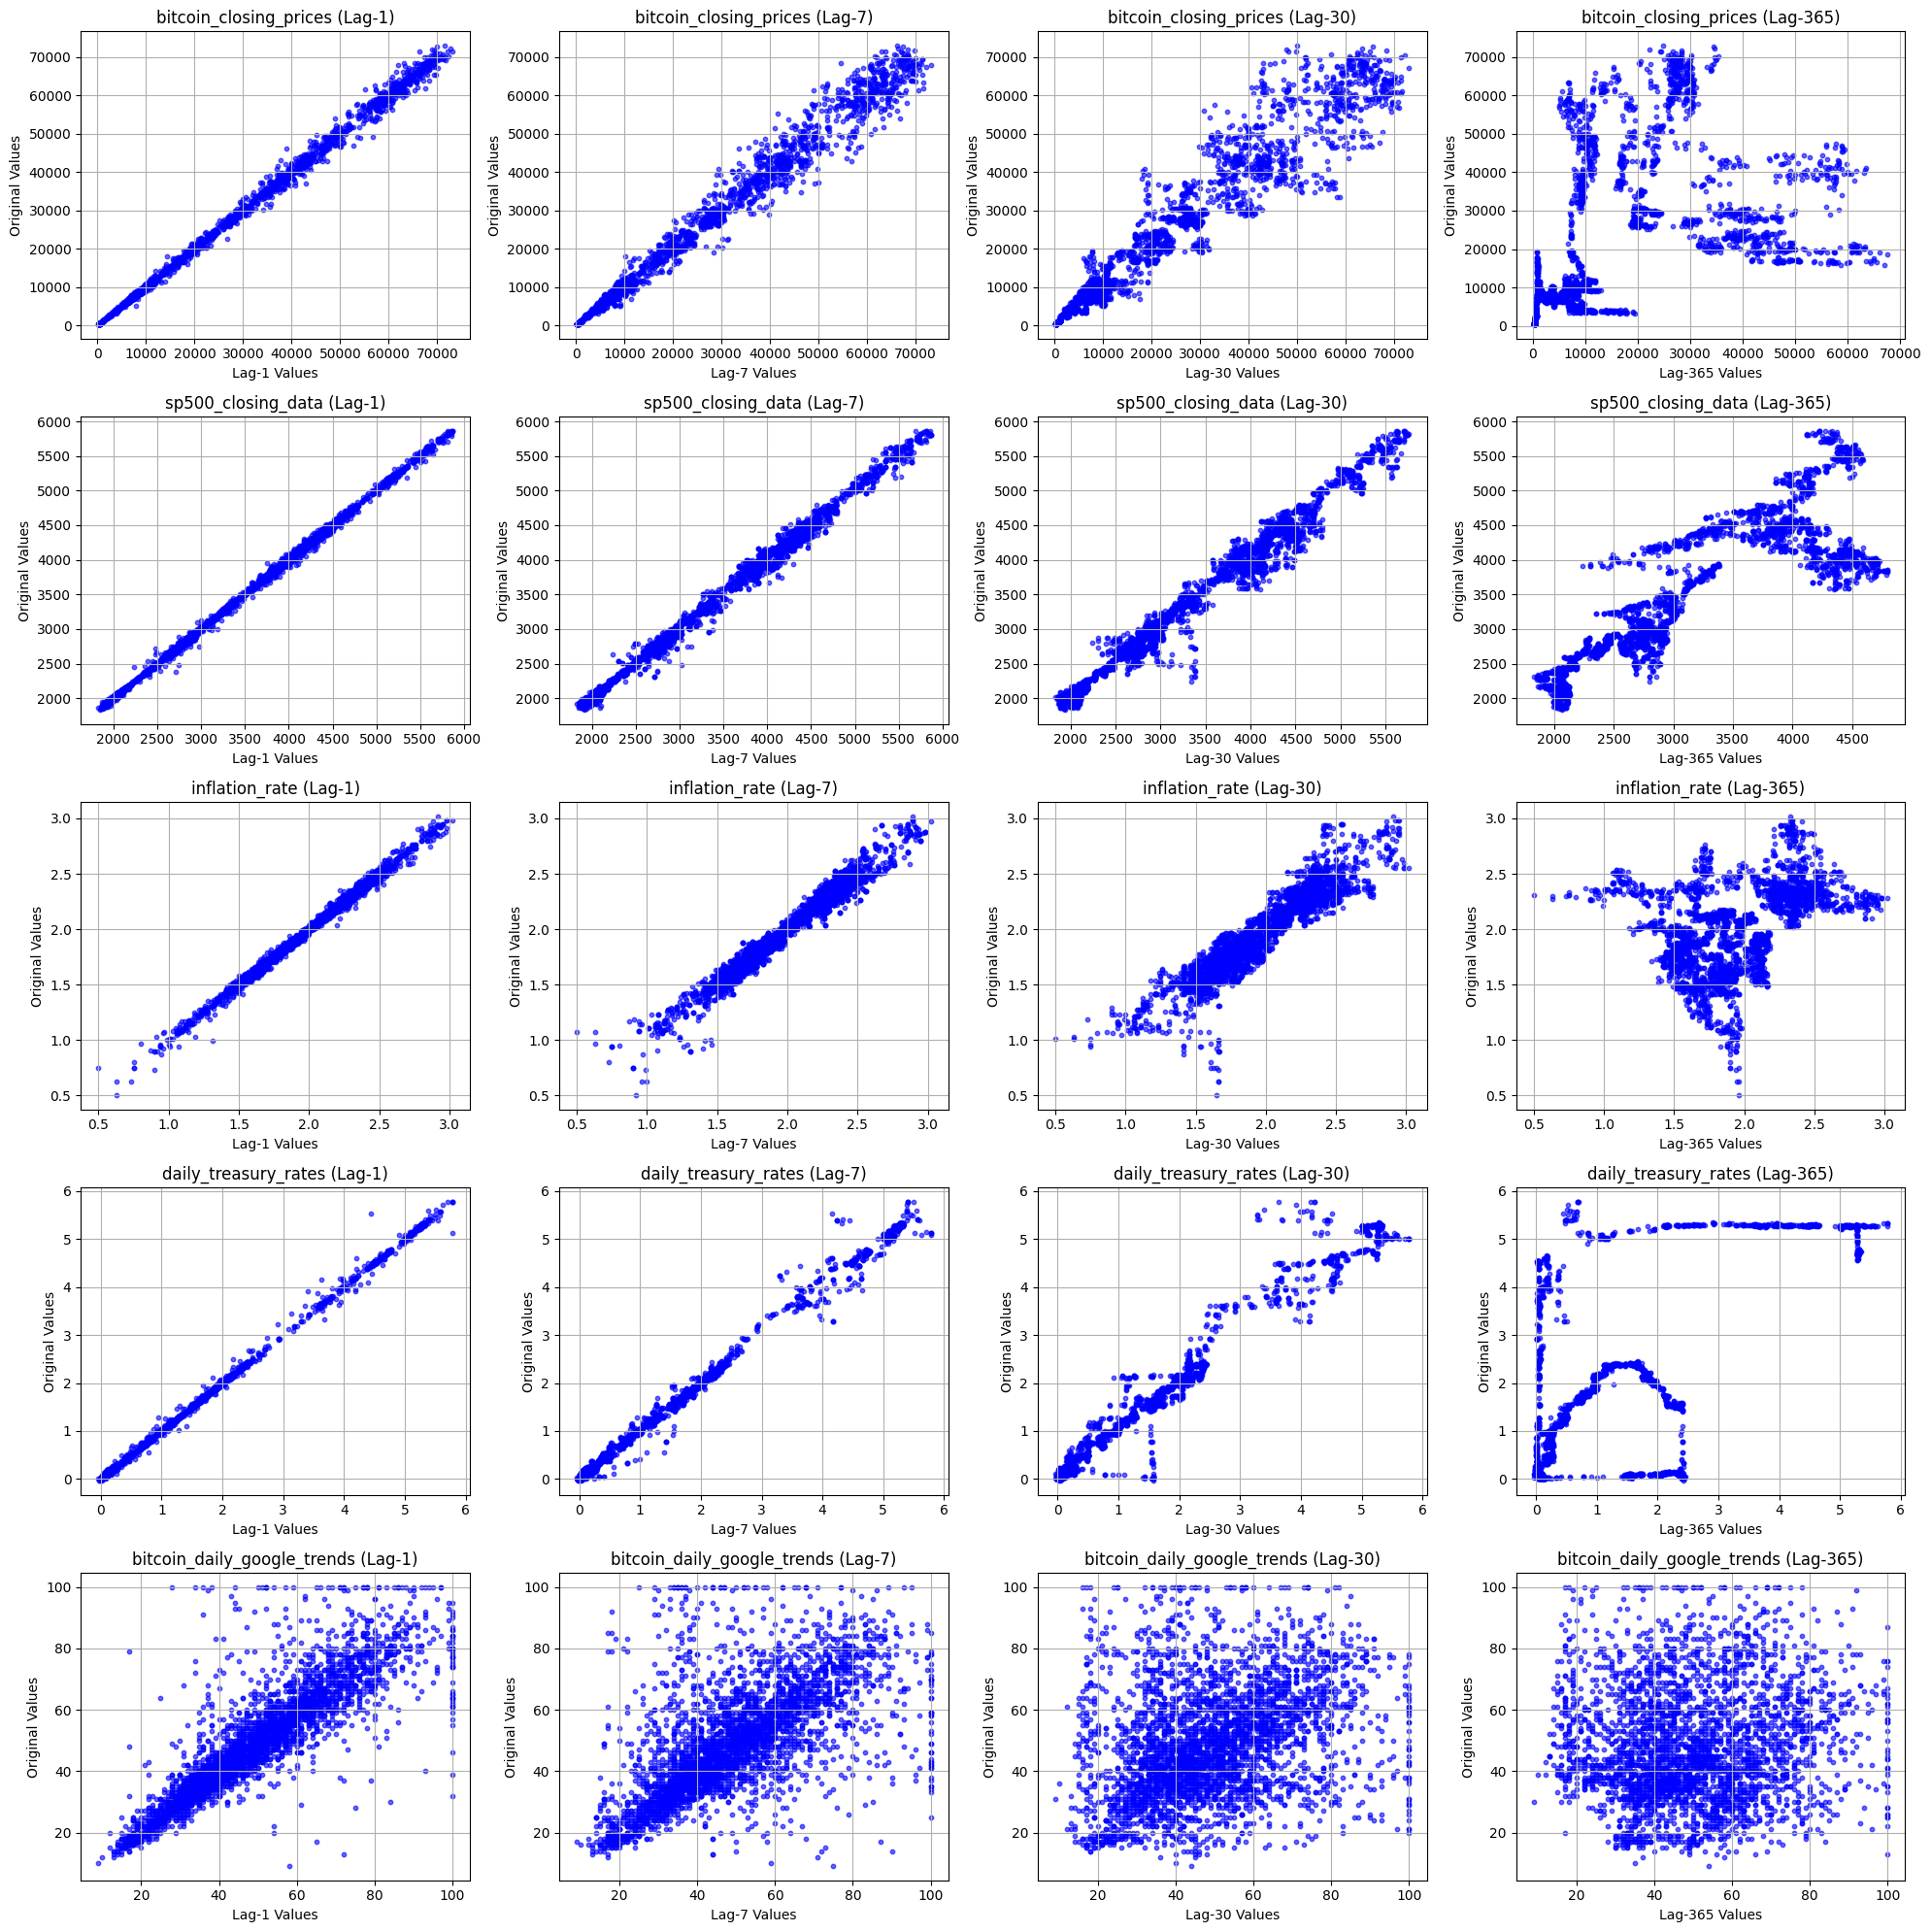

In [33]:
# Lags to plot
lags = [1, 7, 30, 365]

# Function to plot scatter plots for series vs. lagged values in a grid
def plot_lag_scatter_grid(df, variables, lags):
    n_rows = len(variables)  # Rows: one for each variable
    n_cols = len(lags)       # Columns: one for each lag
    fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(5 * n_cols, 4 * n_rows))
    
    for i, var in enumerate(variables):
        data = df[var].dropna()
        
        for j, lag in enumerate(lags):
            lagged_data = data.shift(lag).dropna()
            original_data = data[lag:]  # Align lengths with lagged data
            
            ax = axes[i, j] if n_rows > 1 else axes[j]
            ax.scatter(lagged_data, original_data, alpha=0.6, color='blue', s=10)
            ax.set_title(f"{var} (Lag-{lag})")
            ax.set_xlabel(f"Lag-{lag} Values")
            ax.set_ylabel("Original Values")
            ax.grid()
    
    plt.tight_layout()
    plt.show()

# Plot scatter plots in grid format
plot_lag_scatter_grid(df, variables, lags)

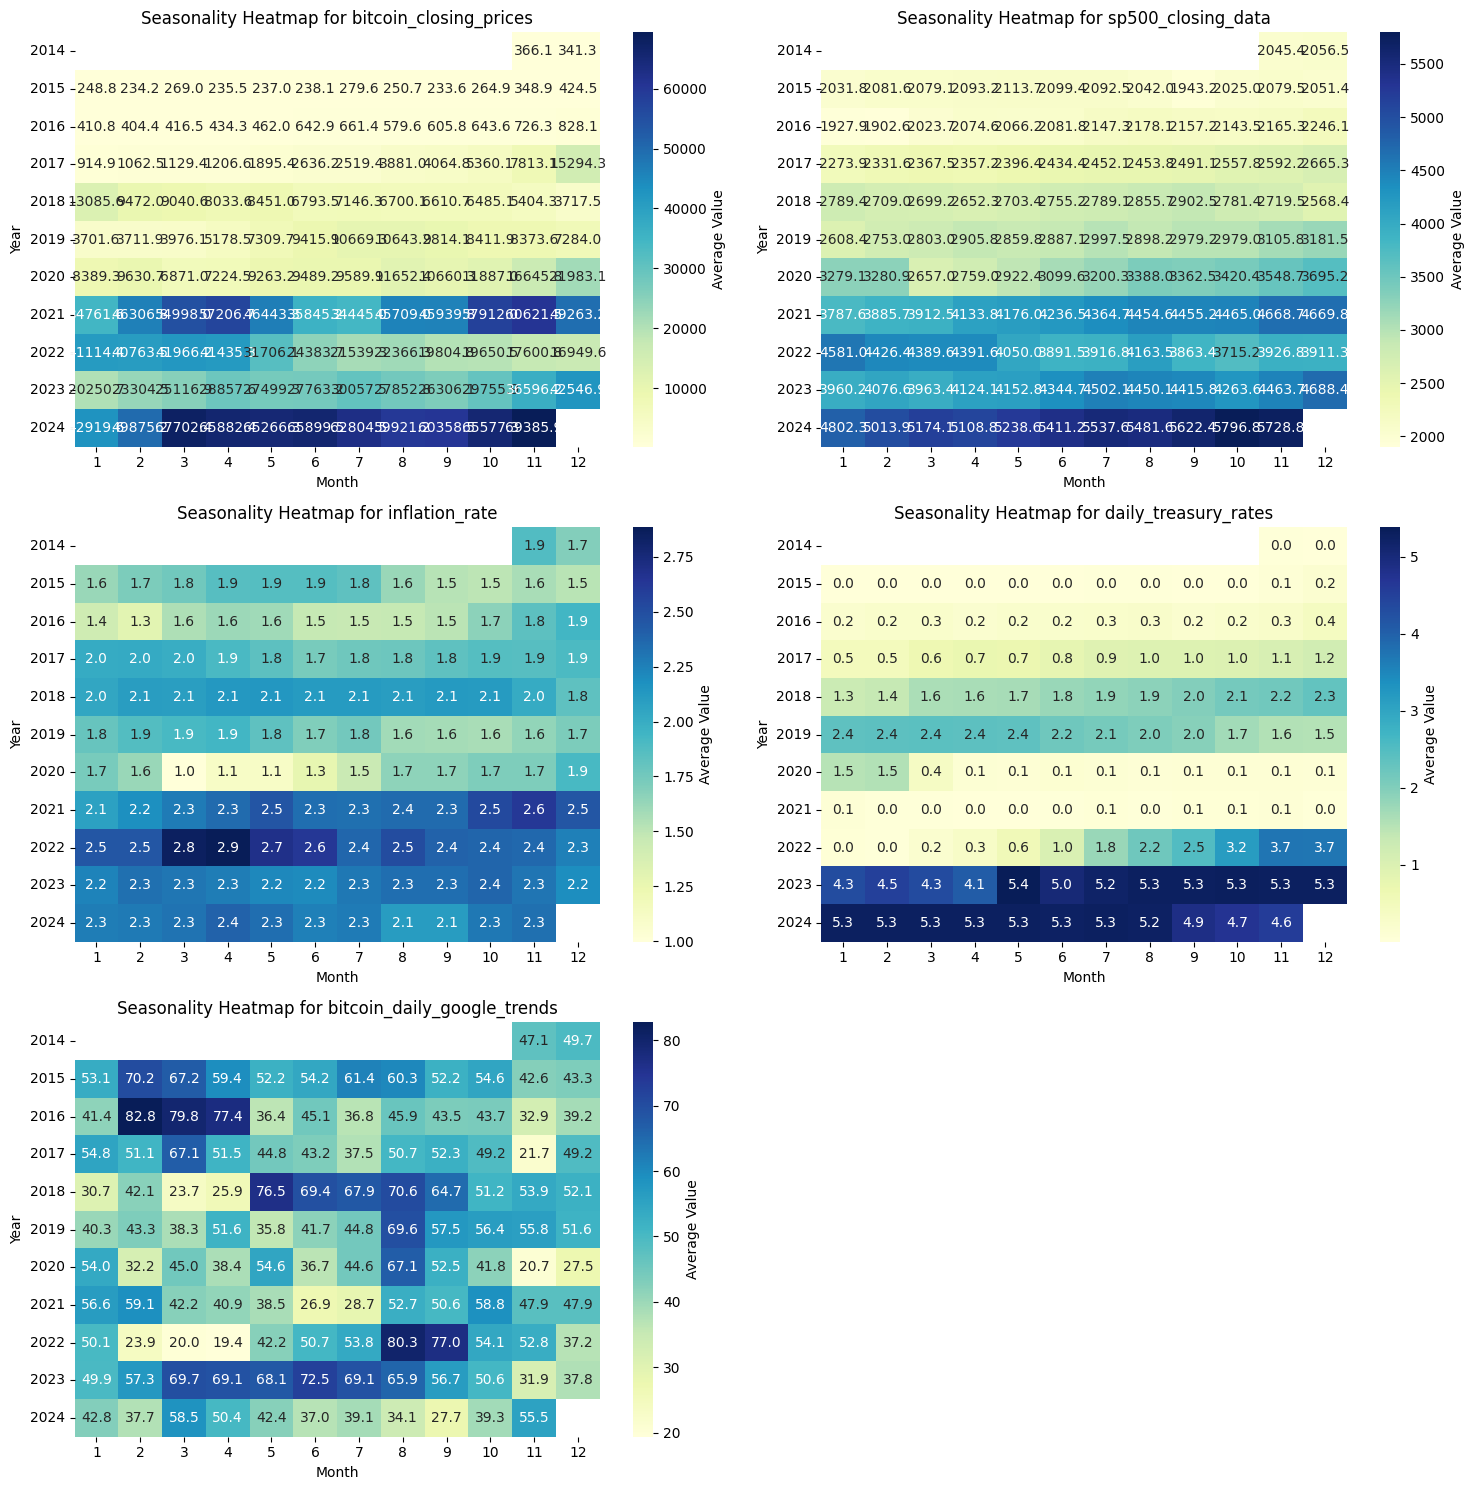

In [34]:
# Create a grid of subplots
n_cols = 2
n_rows = (len(variables) + 1) // 2
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))
axes = axes.flatten()

# Loop through variables to plot each heatmap
for i, variable in enumerate(variables):
    # Group data by year and month and calculate the mean
    grouped = df[variable].groupby([df.index.year, df.index.month]).mean().unstack()
    
    # Create heatmap
    sns.heatmap(
        grouped, 
        cmap="YlGnBu", 
        annot=True, 
        fmt=".1f", 
        ax=axes[i], 
        cbar_kws={'label': 'Average Value'},
    )
    axes[i].set_title(f"Seasonality Heatmap for {variable}")
    axes[i].set_xlabel('Month')
    axes[i].set_ylabel('Year')

# Remove unused subplots
for j in range(len(variables), len(axes)):
    fig.delaxes(axes[j])

# Adjust layout
plt.tight_layout()
plt.show()

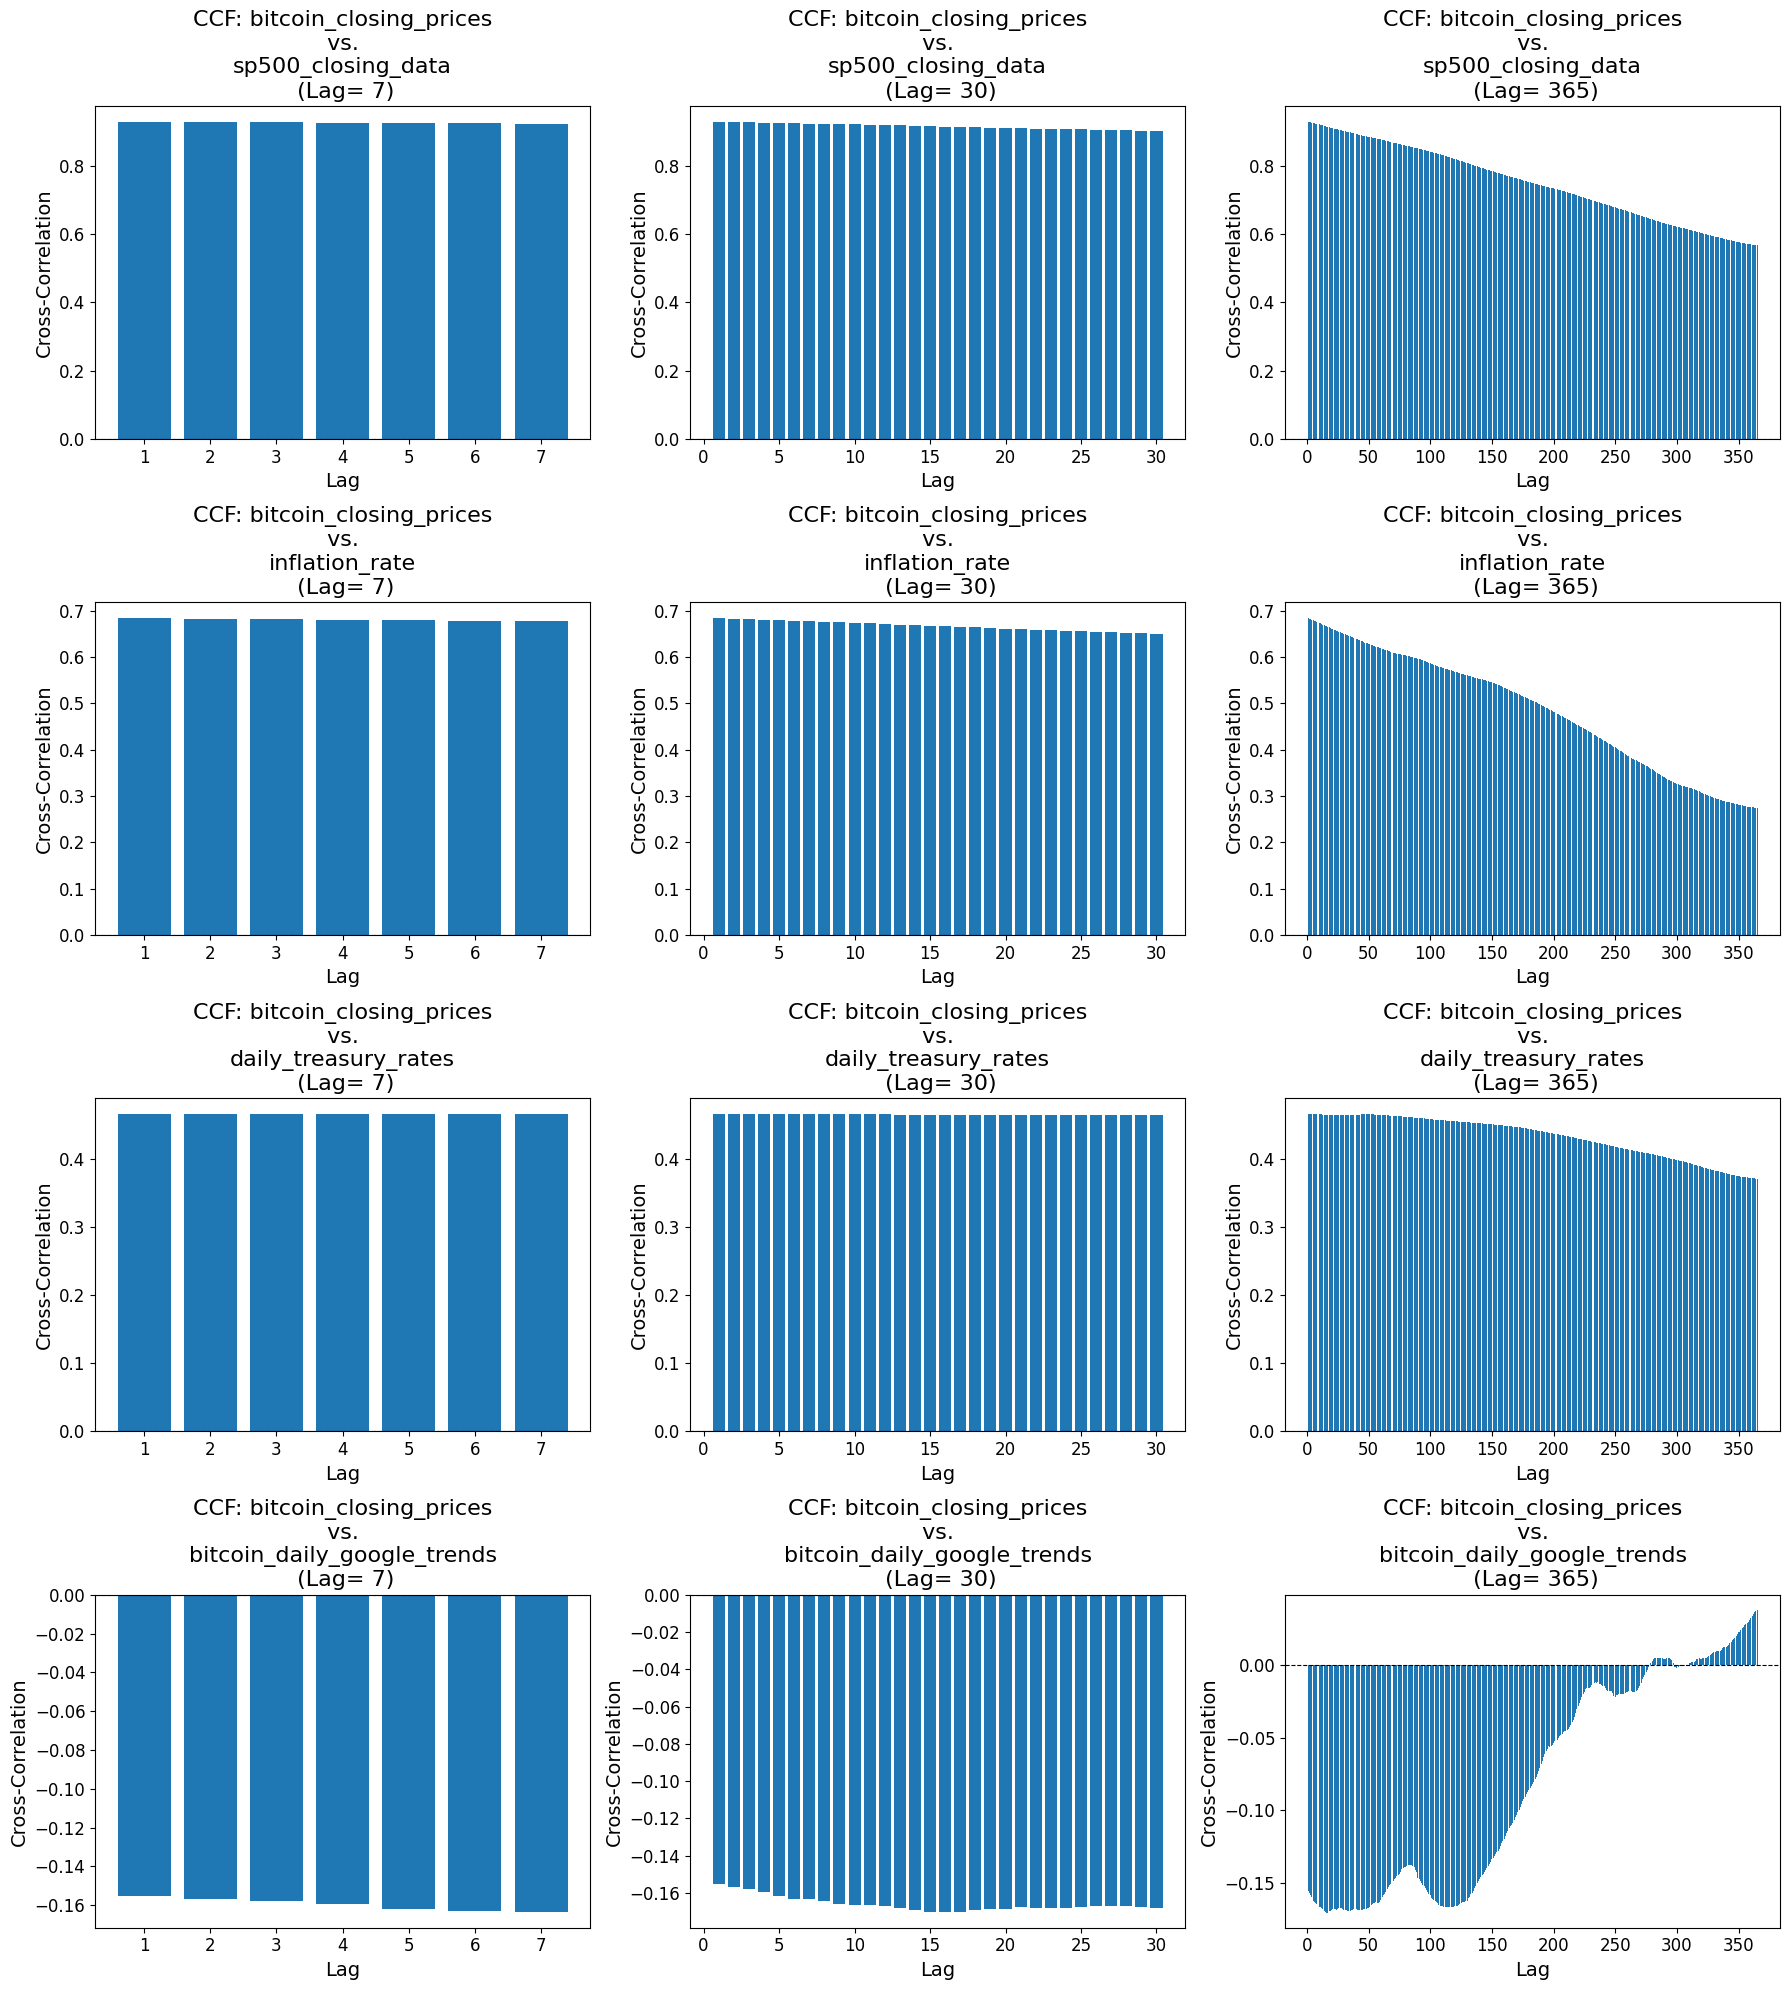

In [35]:
# List of independent variables
independent_vars = [
    'sp500_closing_data',
    'inflation_rate',
    'daily_treasury_rates',
    'bitcoin_daily_google_trends'
]

# Define the specific lags to plot (1 to 7, 1 to 30, 1 to 365)
lags_to_plot = [7, 30, 365]

# Create a grid of subplots for plotting CCF
n_cols = 3  # 3 columns for each lag range (7, 30, 365)
n_rows = len(independent_vars)  # Number of rows equals the number of independent variables
fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 5 * n_rows))
axes = axes.flatten()

# Loop through independent variables to calculate and plot CCF
for i, var in enumerate(independent_vars):
    # Drop NA to avoid misalignment issues
    target = df['bitcoin_closing_prices']
    independent = df[var]
    
    # Align both series (truncate to the same length if necessary)
    min_len = min(len(target), len(independent))
    target = target.iloc[:min_len]
    independent = independent.iloc[:min_len]
    
    # Compute CCF
    cross_corr = ccf(target, independent)
    
    # Plot CCF for each specified range of lags
    for j, max_lag in enumerate(lags_to_plot):
        # Get cross-correlation values for lags up to max_lag
        cross_corr_values = cross_corr[1:max_lag + 1]  # Skip lag 0
        lags = range(1, max_lag + 1)  # Lag values from 1 to max_lag
        
        # Plot the CCF values
        ax = axes[i * n_cols + j]  # Calculate correct axis index
        ax.bar(lags, cross_corr_values)  # Bar plot for the current lag range
        ax.set_title(f"CCF: bitcoin_closing_prices\n vs. \n{var}\n (Lag= {max_lag})", fontsize=16)
        ax.set_xlabel("Lag", fontsize=14)
        ax.set_ylabel("Cross-Correlation", fontsize=14)
        ax.axhline(0, color='black', linewidth=0.8, linestyle='--')  # Baseline
        ax.tick_params(axis='both', labelsize=12)  # Increase font size for ticks

# Adjust layout to avoid overlap
plt.tight_layout()
plt.show()

In [36]:
import os
print(os.getcwd())  # This prints the current working directory
df.to_csv('cleaned_data.csv', index=False)

d:\Advance-Time-Series-Prediction-W24\1_DatasetCharacteristics


In [37]:
'''import pandas as pd
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt

# Assuming df is your dataset and 'bitcoin_closing_prices' is the target variable
X = df[['sp500_closing_data', 'inflation_rate', 'daily_treasury_rates', 'bitcoin_daily_google_trends' ]]
#        'twitter_sentiment_score', 'date', 'month', 'year', 'day_number', 'week_number', 'is_holiday']]  # Independent variables
y = df['bitcoin_closing_prices']  # Dependent variable

# Train a Random Forest model
rf_model = RandomForestRegressor(n_estimators=1000, random_state=42)
rf_model.fit(X, y)

# Get feature importances
importances = rf_model.feature_importances_

# Create a DataFrame to view the feature importances
feature_importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance': importances
})

# Sort by importance
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.barh(feature_importances['Feature'], feature_importances['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.title('Feature Importance (Random Forest)')
plt.show()

# Print the feature importances
print(feature_importances)'''

"import pandas as pd\nfrom sklearn.ensemble import RandomForestRegressor\nimport matplotlib.pyplot as plt\n\n# Assuming df is your dataset and 'bitcoin_closing_prices' is the target variable\nX = df[['sp500_closing_data', 'inflation_rate', 'daily_treasury_rates', 'bitcoin_daily_google_trends' ]]\n#        'twitter_sentiment_score', 'date', 'month', 'year', 'day_number', 'week_number', 'is_holiday']]  # Independent variables\ny = df['bitcoin_closing_prices']  # Dependent variable\n\n# Train a Random Forest model\nrf_model = RandomForestRegressor(n_estimators=1000, random_state=42)\nrf_model.fit(X, y)\n\n# Get feature importances\nimportances = rf_model.feature_importances_\n\n# Create a DataFrame to view the feature importances\nfeature_importances = pd.DataFrame({\n    'Feature': X.columns,\n    'Importance': importances\n})\n\n# Sort by importance\nfeature_importances = feature_importances.sort_values(by='Importance', ascending=False)\n\n# Plot the feature importances\nplt.figure(figs

In [38]:
'''import shap
import pandas as pd
from sklearn.ensemble import RandomForestRegressor

# Assuming df is your dataset and 'bitcoin_closing_prices' is the target variable
X = df[['sp500_closing_data', 'inflation_rate', 'daily_treasury_rates', 'bitcoin_daily_google_trends', ]] #'twitter_sentiment_score', 'date', 'month', 'year', 'day_number', 'week_number', 'is_holiday']]  # Independent variables
y = df['bitcoin_closing_prices']  # Dependent variable

# Train a Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X, y)

# Create a SHAP explainer
explainer = shap.TreeExplainer(rf_model)

# Get SHAP values for the dataset
shap_values = explainer.shap_values(X)

# Plot SHAP summary plot (which shows the importance and distribution of each feature)
shap.summary_plot(shap_values, X, plot_type="bar")

# Plot SHAP force plot (for an individual prediction)
shap.initjs()  # To enable visualization in Jupyter
shap.force_plot(explainer.expected_value[1], shap_values[1][0], X.iloc[0])'''

'import shap\nimport pandas as pd\nfrom sklearn.ensemble import RandomForestRegressor\n\n# Assuming df is your dataset and \'bitcoin_closing_prices\' is the target variable\nX = df[[\'sp500_closing_data\', \'inflation_rate\', \'daily_treasury_rates\', \'bitcoin_daily_google_trends\', ]] #\'twitter_sentiment_score\', \'date\', \'month\', \'year\', \'day_number\', \'week_number\', \'is_holiday\']]  # Independent variables\ny = df[\'bitcoin_closing_prices\']  # Dependent variable\n\n# Train a Random Forest model\nrf_model = RandomForestRegressor(n_estimators=100, random_state=42)\nrf_model.fit(X, y)\n\n# Create a SHAP explainer\nexplainer = shap.TreeExplainer(rf_model)\n\n# Get SHAP values for the dataset\nshap_values = explainer.shap_values(X)\n\n# Plot SHAP summary plot (which shows the importance and distribution of each feature)\nshap.summary_plot(shap_values, X, plot_type="bar")\n\n# Plot SHAP force plot (for an individual prediction)\nshap.initjs()  # To enable visualization in Jupy

In [39]:
'''import shap
import pandas as pd
from sklearn.ensemble import RandomForestRegressor

# Assuming df is your dataset and 'bitcoin_closing_prices' is the target variable
X = df[['sp500_closing_data', 'inflation_rate', 'daily_treasury_rates', 'bitcoin_daily_google_trends']]  # Independent variables
y = df['bitcoin_closing_prices']  # Dependent variable

# Train a Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X, y)

# Create a SHAP explainer
explainer = shap.TreeExplainer(rf_model)

# Get SHAP values for the dataset
shap_values = explainer.shap_values(X)

# Plot SHAP summary plot (which shows the importance and distribution of each feature)
shap.summary_plot(shap_values, X, plot_type="bar")

# Plot SHAP force plot (for an individual prediction)
shap.initjs()  # To enable visualization in Jupyter

# Convert shap_values to an Explanation object for the first prediction
# Create a SHAP Explanation object for the first sample (index 0)
shap_values_explanation = shap.Explanation(shap_values[0], X)

# Use the Explanation object in the force plot
shap.force_plot(explainer.expected_value, shap_values_explanation.values[0], shap_values_explanation.data[0], feature_names=X.columns)'''

'import shap\nimport pandas as pd\nfrom sklearn.ensemble import RandomForestRegressor\n\n# Assuming df is your dataset and \'bitcoin_closing_prices\' is the target variable\nX = df[[\'sp500_closing_data\', \'inflation_rate\', \'daily_treasury_rates\', \'bitcoin_daily_google_trends\']]  # Independent variables\ny = df[\'bitcoin_closing_prices\']  # Dependent variable\n\n# Train a Random Forest model\nrf_model = RandomForestRegressor(n_estimators=100, random_state=42)\nrf_model.fit(X, y)\n\n# Create a SHAP explainer\nexplainer = shap.TreeExplainer(rf_model)\n\n# Get SHAP values for the dataset\nshap_values = explainer.shap_values(X)\n\n# Plot SHAP summary plot (which shows the importance and distribution of each feature)\nshap.summary_plot(shap_values, X, plot_type="bar")\n\n# Plot SHAP force plot (for an individual prediction)\nshap.initjs()  # To enable visualization in Jupyter\n\n# Convert shap_values to an Explanation object for the first prediction\n# Create a SHAP Explanation objec

In [40]:
# End timing
end_time = time.time()
execution_time = end_time - start_time

# Print execution time
print(f"Execution time: {execution_time:.2f} seconds")

Execution time: 65.98 seconds
